# 引言

## 研究目的

### 参考光大证券研报《20190615-光大证券-多因子系列报告之二十二：再论动量因子》，对传统动量因子进行分析探究，并根据研报方式对传统动量因子进行改造，寻找提升因子效果的方法

## 研究思路

### 1.模仿研报方式，对各传统动量因子进行相应的分析

### 2.参考研报方式对传统动量因子进行改造，并模仿研报方式进行类似的分析以及和原动量因子的对比

### 3.根据自己的理解，对构造的各因子进行进一步的分析

### 4.结合模仿研报的分析以及自己对各因子的分析，尝试寻找表现最优的动量相关因子，并尝试借此构建策略

## 研究结论

### 1.和研报不同，构造的一个月传统动量因子本身的单调性等表现不错，因此模仿研报方式改造的前几个动量因子相较于一个月传统动量因子并没有十分显著的提升

### 2.

### 6.尽管和研报结论有一定出入，但成交额改造k线下的因子确实多头表现优秀，综合各种测试，选用表现最好的改造k线因子并结合传统动量因子构建策略，策略在13-17年，19年确实有不错的表现

## 研究设置

### 时间范围：日度因子：2006.01.01 - 2019.05.31

###                  分钟数据因子：2009.01.01 - 2017.12.31

### 股票池： 中证全指

In [ ]:
''' --------------------↓      开始研究      ↓-------------------- '''

# 1.导入库

In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/21782
# 标题：精英任务获奖作品——作者：Ian666

import pandas as pd
import numpy as np
from jqdata import * 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from tqdm import tqdm
import statsmodels.api as sm #剔除流动性时使用
from statsmodels.regression.linear_model import OLS  #这里是用截面OLS取残差，有一定缺陷
from scipy.stats import ttest_1samp  #t检验
from IPython.display import display
from jqfactor import neutralize  #主要用于行业市值中性化
from jqfactor import get_factor_values   #获取大类因子
import time
import datetime
import os
import warnings
warnings.filterwarnings('ignore')
sns.set()
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 2.数据读取、计算和储存

## （1）基本数据的读取和储存

In [ ]:
save_path = r'D:\mom'
os.chdir(save_path)  #开始计算和存储数据，设定存储路径
zzqz = get_index_stocks('000985.XSHG')  #在中证全指测试
open_close = get_price(zzqz,fields=['close','open','paused'],start_date='2006-01-01',end_date='2019-05-31')  #收盘开盘停牌
paused = open_close['paused']
open_ = open_close['open']
close = open_close['close']
st = get_extras('is_st', zzqz, start_date='2006-01-01', end_date='2019-05-31') #st
st.to_csv('st06.csv') #储存
open_.to_csv('open_06.csv')
close.to_csv('close06.csv')
paused.to_csv('paused06.csv')

## （2）大类因子的读取、计算、储存

In [ ]:
#循环读取各大类因子
factors = ['liquidity','market_cap','circulating_market_cap','size','book_to_price_ratio','VOL20','roe_ttm']  
for fac_name in factors:
    dic = {}
    for date in tqdm(close.index): #循环日期读取，读取时间区间和前面一致，这里由于get_factor_values有最大返回条数限制，只好一天一天读了
        dic[date] = get_factor_values(zzqz,factors=[fac_name],start_date=date,end_date=date)[fac_name].iloc[0]
    factor = pd.DataFrame.from_dict(dic,'index')
    name = fac_name + '.csv'
    factor.to_csv(name)
#计算研报中大类因子fc_mc，自由流通市值/总市值
market_cap = pd.read_csv('market_cap.csv',index_col=0,parse_dates=True)
circulating_market_cap = pd.read_csv('circulating_market_cap.csv',index_col=0,parse_dates=True)
fc_mc = circulating_market_cap/market_cap
fc_mc.to_csv('fc_mc.csv')

## （3）常用动量因子

In [ ]:
'''
滚动计算，最后测试的因子结论和研报有些地方不同，个人认为有很多原因，这里应该是一个，不清楚研报是否用的收盘价，以及是否滚动，滚动的话是多少天
这些计算方式上的差异都可能导致最后结果和研报并不完全相同，后面涉及到相应的计算部分会进一步解释
'''
mom_1m = close.pct_change(20) #用收盘价计算动量
mom_3m = close.pct_change(60)
mom_6m = close.pct_change(120)
mom_12m = close.pct_change(240)
mom_24m = close.pct_change(480)
mom_1m_max = close.pct_change().rolling(20,min_periods=12).max()[close.notnull()] #一个月收益率最大值

## （4）预处理函数

In [ ]:
def winsorize(df, nsigma=3): #去极值，MAD法，超过md +/- 3*mad的部分将按大小排序拉回
    md = df.median(axis=1)
    mad = 1.483 * (df.sub(md, axis=0)).abs().median(axis=1)
    up = df.apply(lambda k: k > md + mad * nsigma)
    down = df.apply(lambda k: k < md - mad * nsigma)
    df[up] = df[up].rank(axis=1, pct=True).multiply(mad * 0.5, axis=0).add(md + mad * nsigma, axis=0)

    df[down] = df[down].rank(axis=1, pct=True).multiply(mad * 0.5, axis=0).add(md - mad * (0.5 + nsigma), axis=0)

    return df
def standarize(df): #截面标准化
    return df.sub(df.mean(axis=1),axis=0).div(df.std(axis=1),axis=0)
    '''
#横截面行业市值中性化，对数市值和申万1级行业，这里是和研报不同的另一个地方，研报采用中信1级行业，可能也是导致后续结论略不同的原因之一
    '''
#因为要循环横截面中性化，比较耗时
#本来是想用中信1级的但是没在聚宽找着这个分类。。就干脆用申万1级了
def neutralize_(df):  
    res_dic = {}
    for date in tqdm(df.index):
        res_dic[date] = neutralize(df.loc[date,:], how=['sw_l1','size'], date=date, axis=1)
    return pd.DataFrame.from_dict(res_dic,'index')
def format_factor(factor):  #综合上面的三个函数，预处理因子，去极值、标准化、行业市值中性化
    adjfactor = winsorize(factor)
    adjfactor = standarize(adjfactor)
    adjfactor = neutralize_(adjfactor)
    return adjfactor

## （5）预处理动量因子

In [ ]:
mom_1m = format_factor(mom_1m)  #计算并存储预处理后的因子
mom_3m = format_factor(mom_3m)
mom_6m = format_factor(mom_6m)
mom_12m = format_factor(mom_12m)
mom_24m = format_factor(mom_24m)
mom_1m_max = format_factor(mom_1m_max)
mom_1m.to_csv('mom_1m_fmt.csv')
mom_3m.to_csv('mom_3m_fmt.csv')
mom_6m.to_csv('mom_6m_fmt.csv')
mom_12m.to_csv('mom_12m_fmt.csv')
mom_24m.to_csv('mom_24m_fmt.csv')
mom_1m_max.to_csv('mom_1m_max_fmt.csv')

## （6）趋势动量因子的计算和储存

In [ ]:
#趋势动量因子的计算
'''
#这里是简单计算了移动平均MA，这里也涉及到计算方式不同的问题
#比如用开盘价还是用收盘价，是否加Min_periods（因为滚动期太长，不然可能很多空值，例如不加的话一天空值会导致后面240天的滚动都是空值）
#以及是否用MA计算收益率作为趋势动量因子
'''
ma_20 = close.rolling(20,min_periods=10).mean()[close.notnull()]/close

ma_60 = close.rolling(60,min_periods=40).mean()[close.notnull()]/close

ma_120 = close.rolling(120,min_periods=80).mean()[close.notnull()]/close

ma_240 = close.rolling(240,min_periods=160).mean()[close.notnull()]/close

ma_20 = format_factor(ma_20)
ma_60 = format_factor(ma_60)
ma_120 = format_factor(ma_120)
ma_240 = format_factor(ma_240)
ma_20.to_csv('D:/mom/ma_20_.csv')
ma_60.to_csv('D:/mom/ma_60_.csv')
ma_120.to_csv('D:/mom/ma_120_.csv')
ma_240.to_csv('D:/mom/ma_240_.csv')

## （7）提纯动量因子计算和储存

In [ ]:
'''
#OLS横截面回归，取残差，剔除流动性和fc_mc
#这里的问题是研报回归是否采用的是OLS（因为实际上OLS有一定不好的地方，只是图方便。。因为数据量比较大用WLS之类的会更慢）
#我直接用预处理后的一个月动量进行剔除，剔除后就不再进行中性化了
'''
def neutralize_by_liqfcmc(to_neu_factor, liquidity, fc_mc):
    '''
    参数：
    to_neu_factor：要中性化的因子
    liquidity： 聚宽提取的流动性因子
    fc_mc： 用聚宽提取的自由市值和总市值计算的，自由流通市值/总市值
    
    返回：
    中性化后的因子df
    
    
    '''
    factor = to_neu_factor.copy()

    dic = {}
    for date in tqdm(factor.index): #循环横截面
        liq = liquidity.loc[date, :]  #取出当天流动性和fc_mc的值
        fc = fc_mc.loc[date, :]
        x = sm.add_constant(pd.concat([liq, fc], axis=1))  #添加常数并拼接
        y = factor.loc[date, :]
        mask = y.notnull() & x.notnull().all(axis=1)  #剔除缺失值
        x1 = x[mask]
        y1 = y[mask]
        if len(y1) == 0:  #如果剔除后没有值了直接跳过
            continue
        est = OLS(y1, x1).fit()  #回归取残差
        resid = pd.Series(est.resid, index=y1.index)
        assert not resid.isnull().any()

        dic[date] = resid
    #将残差数据去极值标准化并调成和原因子相同维度
    newfactor = standarize(winsorize(pd.DataFrame.from_dict(dic, 'index')).loc[to_neu_factor.index, 
                                                                               to_neu_factor.columns]).reindex_like(to_neu_factor)
    newfactor[factor.isnull()] = np.nan
    return newfactor
liquidity = pd.read_csv('liquidity.csv',index_col=0,parse_dates=True)
fc_mc = pd.read_csv('fc_mc.csv',index_col=0,parse_dates=True)
mom_1m_neu = neutralize_by_liqfcmc(mom_1m, liquidity, fc_mc)
mom_1m_neu.to_csv('mom_1m_neu.csv')

## （8）残差动量因子计算和储存

In [ ]:
#Fama-French三因子时间序列回归
'''
#这里涉及到的问题是研报是否用的滚动收益率回归，SMB和HML的计算方式，是否滚动计算、回归的方式等
#我用的是预处理前的一个月动量进行时间序列回归
'''
mom_1m = close.pct_change(20)
mkt = close.pct_change(20).mean(axis=1) #一个月动量市场
market_cap_2 = market_cap.quantile(0.2,axis=1)  #小市值，市值在横截面0.2分位数下被定义为小市值（实际上这些参数也很主观，也会导致结果不同）
market_cap_8 = market_cap.quantile(0.8,axis=1)  #大市值
market_cap_2_ret = close.pct_change(20)[market_cap.le(market_cap_2,axis=0)].mean(axis=1)
market_cap_8_ret = close.pct_change(20)[market_cap.ge(market_cap_8,axis=0)].mean(axis=1)
SMB = market_cap_2_ret - market_cap_8_ret  #SMB，小市值减大市值
book_to_price_ratio_2 = book_to_price_ratio.quantile(0.2,axis=1)  #同上，bp高减低
book_to_price_ratio_8 = book_to_price_ratio.quantile(0.8,axis=1)
book_to_price_ratio_2_ret = close.pct_change(20)[book_to_price_ratio.le(book_to_price_ratio_2,axis=0)].mean(axis=1)
book_to_price_ratio_8_ret = close.pct_change(20)[book_to_price_ratio.ge(book_to_price_ratio_8,axis=0)].mean(axis=1)
HML = book_to_price_ratio_8_ret - book_to_price_ratio_2_ret
dic = {}
#这里的问题仍然是是否采用OLS，以及是否加入常数项
for col in tqdm(mom_1m.columns):  #循环股票做时间序列回归取残差
    y = mom_1m[col]
    x = pd.concat([mkt,SMB,HML],axis=1) #这里我没加常数项，后面解释同上
    mask = y.notnull() & x.notnull().all(axis=1)
    x1 = x[mask]
    y1 = y[mask]
    if len(y1) == 0:
        continue
    est = OLS(y1, x1).fit()
    resid = pd.Series(est.resid, index=y1.index)
    assert not resid.isnull().any()
    dic[col] = resid
mom_1m_resid = standarize(winsorize(pd.DataFrame.from_dict(dic, 'columns')).loc[mom_1m.index, mom_1m.columns]).reindex_like(mom_1m)
mom_1m_resid[mom_1m.isnull()] = np.nan

## （9）k线改造动量因子计算和储存

In [ ]:
'''
#计算改造k线因子，这里计算涉及到分钟数据以及改造k线的一些操作，计算起来比较慢，主要运用pd.cut进行对成交额/量等额切分分组
#因为考虑到研报应该大都进行月度分析，这里我就将计算结果保留为月频了，后面的计算中有相应解释
'''
zzquanzhi = get_index_stocks('000985.XSHG')
index = get_trade_days(start_date='2009-01-01',end_date='2017-12-31')
information = get_all_securities(types=['stock'], date=None)  #取出股票上市时间信息
#剔除那些17年6月之后才上市的股票，这里主要是避免有的股票没上市在计算时出bug，实际上根据后面的新上市1年内股票的剔除这些数值也会被剔除
filter_ = information[information['start_date'] >= datetime.date(2017,6,1)].index  
stocks = list(filter(lambda x: x not in filter_, zzquanzhi))  #过滤股票池
touseclose = close.loc['2009-01-01':'2017-12-31',:]  #用于后面设定改造k线数量
def changebar(minute_data, method, bins):   #改造k线，根据成交量或者成交额，改造k线表示每根k线有接近的成交量/额（因为很难做到完全相同）
    '''
参数：
minute_data: pd.DataFrame  某股票的分钟数据，包含收盘价、成交额、成交量数据
method： str  'money' or 'volume'  改造k线的方法，money表示等成交额，volume表示等成绩量
bins： int  改造k线的根数，这个参数后面有计算，会进一步说明
返回：
pd.DataFrame  index是时间，对应的数据为每根改造k线的最后一个分钟数据
    '''
    
    
    minute_data = minute_data.reset_index() #先把index reset进df，因为最后要把改造k线的数据换回时间序列，不然很难搭回测和IC
    '''  ！！改造k线的逻辑如下，略长，我尽可能的解释我的改造思路了。。
    下面一步是切分成交量/额，首先对其cumsum，再根据bins的数量切分，由于pd.cut会将每个值分在区间宽度一致的区间内
    而cumsum值的作差是新产生的量，因此被cut后分在同一区间内的可以认为是同一根k线内的数据，而这根k线发生的成交量/额大概是区间宽度
    cumsum后值是递增的，因此切分后的分组也是递增的，也就是给每分钟的数据划分组别，属于第几根改造k线
    cut后的值会变成其对应所在的区间，因此根据bins 的值设置labels，1……bins 直接分好组名，同组的表示同一根k线内的数据，bins即总k线数量
    由于分组后标签的值是个很奇怪的属性，所以先将其str 后转为float，方便后续分析
    ffill主要是把缺失值的地方用之前的组填充，即缺失值位置认为属于前一个数据的k线
    这样处理后 成交量/额这一列就变成了k线的分组
    
    举个栗子：成交额序列为 [9, 5, 8, 15, 11, 17, 13, 15, 12, 16] 十个数，
                cumsum后是[9, 14, 22, 37, 48, 65, 78, 93, 105, 121]
            给定label为1~3后pd.cut后是[1, 1, 1, 1, 2, 2, 2, 3, 3, 3]
            前四分钟属于一根成交额k线，之后三分钟、三分钟分别属于同一根成交额k线，共3根成交额k线
            发生的成交额总和为 1：37，2：41， 3：43   是比较接近的
            这里需要注意的是构造根数应该要小于分钟k线数一定量，也就是保证改造k线里的分钟k线数量不要太少，不然可能对极端成交额会有问题
    这么解释应该可以了吧。。
    '''
    minute_data[method] = pd.cut(minute_data[method].cumsum(), bins=bins,
                                labels=np.arange(1,bins+1)).astype(str).astype(float).ffill()
    #将k线分组这一列设为index，groupby取出每组最后一个值，即每根k线的收盘价
    #每个股票分组的情况都不一样，因此后面调成月频
    methodbar = minute_data.set_index(method).groupby(level=0).\
                apply(lambda df:df.iloc[-1])[['index','close']]
    return methodbar.set_index('index') #输出的时候将时间index重新set回来，因为最后要调成时间序列的数据

def cal_method_fac(minute_data, method, number, bins, index):
    '''
参数：
minute_data: pd.DataFrame  某股票的分钟数据，包含收盘价、成交额、成交量数据
method： str  'money' or 'volume'  改造k线的方法，money表示等成交额，volume表示等成绩量
number： int  计算动量的k线数量
bins： int  改造k线的根数，这个参数后面有计算，会进一步说明
index： list  这个是第一步取得的交易日序列，用于把最后输出的数据调成时间序列
返回值：
index是日，每个月的值都相同，都为上个月月末的因子值的df，只有一列，列名是close
    '''   
    methodbar = changebar(minute_data, method=method, bins=bins)  #得到改造k线后的数据，得到的是每根k线的收盘价
    methodbar_mom = methodbar.pct_change(number)  #计算number根k线 的动量
    methodbar_mom_month = methodbar_mom.groupby(pd.Grouper(freq='M')).apply(lambda df:df.tail(1))  #取出每个月的最后一个因子值
    methodbar_mom_month.index = methodbar_mom_month.index.get_level_values(1).date  #index调一下
    #shift是将当月末的因子值移至下个月末，然后前置填充
    methodbar_mom_month = methodbar_mom_month.shift().\
                                            reindex_like(pd.DataFrame(index=index,#    emmm这一步写的时候没多想，这里太麻烦了，直接用.loc[index,:].bfill()应该就行
                                                    columns=['close']),method='bfill')
    return methodbar_mom_month   
def cal_k_fac(minute_data, number, index, stock):  #综合上面的函数计算，股票循环
    day = touseclose[stock].dropna(how='all')  #这里得到当前股票日频数据k线的数量
    '''
 #这一步是根据日频k线数量设定切分后k线的数量，根据这个式子，例如有1350根日k线，那么构造2300根改造k线
#这个参数比较主观，我的做法和研报似乎不太一样，研报具体也没说构造了多少根改造k线，只说保持它们在同一数量级下
#后续会有对这两个参数的敏感性分析   
    '''
    bins = ((len(day) // 100)+10)*100  
    volumebar_mom_month = cal_method_fac(minute_data, method='volume', number=number, bins=bins, index=index)
    moneybar_mom_month = cal_method_fac(minute_data, method='money', number=number, bins=bins, index=index)
    return volumebar_mom_month['close'], moneybar_mom_month['close']  #要取出series，才能用dict生成df

volume60 = {} #用dict存储每只股票处理后的数据，60跟改造k线的动量
money60 = {}
for stock in tqdm(stocks): #循环股票跑，因为每只股票改造情况可能不同，而且要同时取出三类数据，不太好同时运算
    minute_data = get_price(stock, fields=['close','volume','money'], 
                           frequency='1m', start_date='2009-01-01', end_date='2018-01-01')
    volume60[stock], money60[stock] = cal_k_fac(minute_data, number=60, index=index, stock=stock)
volume60 = pd.DataFrame.from_dict(volume60,'columns')
money60 = pd.DataFrame.from_dict(money60,'columns')
volume60.to_csv('D:/mom/volume60.csv')
money60.to_csv('D:/mom/money60.csv')

volume120 = {}  #120根改造k线动量
money120 = {}
for stock in tqdm(stocks):
    minute_data = get_price(stock, fields=['close','volume','money'], 
                           frequency='1m', start_date='2009-01-01', end_date='2018-01-01')
    volume120[stock], money120[stock] = cal_k_fac(minute_data, number=120, index=index, stock=stock)
volume120 = pd.DataFrame.from_dict(volume120,'columns')
money120 = pd.DataFrame.from_dict(money120,'columns')
volume120.to_csv('D:/mom/volume120.csv')
money120.to_csv('D:/mom/money120.csv')

#针对改造k线的月度数据进行中性化
def neutralize_month(factor):
    monthf = factor.groupby(pd.Grouper(freq='M')).apply(lambda df:df.tail(1)) #取出每月最后一天，实际它应该对应上个月月末
    monthf.index = monthf.index.droplevel(0)
    monthf = monthf.shift(-1)#调回因子值正确的日期
    dic = {}
    for date in tqdm(monthf.index):#对每月最后一天做中性化
        dic[date] = neutralize(monthf.loc[date,:], date=date, how=['sw_l1','size'])
    newf = pd.DataFrame.from_dict(dic,'index')
    newf = newf.shift().reindex_like(factor,method='bfill')  #调回原格式
    return newf
    '''
这里构造处理的方式和研报好像差别还挺大，切分k线上应该没啥问题吧。。
我重复审查了思路很多遍，应该这样做确实保证了分在同组的分钟数据会发生接近的成交额/量
但是k线数量这些因素只好自己确定
也只是自己主观的定，而且月度数据并未进行去极值和标准化（这个可能也有影响）
最后我算的改造k线动量的回测和研报的IC是反向的，但同样多头表现很好，后面会具体分析，没能构造出研报效果的改造k线因子，比较遗憾
    '''
volume60_neutralized = neutralize_month(volume60)
volume120_neutralized = neutralize_month(volume120)
money60_neutralized = neutralize_month(money60)
money120_neutralized = neutralize_month(money120)
volume60_neutralized.to_csv('volume60_neutralized.csv')
volume120_neutralized.to_csv('volume120_neutralized.csv')
money60_neutralized.to_csv('money60_neutralized.csv')
money120_neutralized.to_csv('money120_neutralized.csv')

# 3.定义自己的因子测试类

##  因子类介绍 
下面的代码比较长，涉及了研报复现的函数和自己的测试函数，这里对后面的因子测试类进行统一的介绍和函数说明：

### Factor_test 因子测试的类
Factor_test(factor_df, fac_name, open_, close, paused, st, #因子相关的数据

  mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,  #常用大类因子及1月动量
                
   ismonth=False)  #传入数据是否是月度数据（后面有解释）
                
##### 参数：
factor_df: pd.DataFrame 要分析的因子数据，格式要求：index为时间，columns为股票代码（后续传入的数据也是这个格式）
                        有日度数据和月度数据两种形式，月度数据是将每个月月底的因子值shift至下个月月末并前置填充
                        即月度数据同样是日频数据，但是每个月的数据是相同的，都是上个月月末的因子值
                        当传入月度数据时需要调用ismonth（这个很重要，因子月度数据处理方式和日度不一样）
                        
fac_name : str          因子名，用于绘图等

open_ : pd.DataFrame    开盘价，用于计算未来收益率

close: pd.DataFrame     收盘价，（其实没啥用，计算一个月波动率用的，也可以外面计算好然后在大类因子直接传入，懒得改了。。）

paused: pd.DataFrame    停牌情况，从聚宽读取的0,1数据df（注意后面代码进行了==1的判断，因此不能直接传入布尔值）

st: pd.DataFrame        st股，聚宽读取的，直接传入即可

mom_1m: pd.DataFrame    一个月动量因子值，因为研报有一些和原动量的对比

roe_ttm: pd.DataFrame   常用大类因子roe_ttm，权益回报率TTM

va_fc_1m: pd.DataFrame  常用大类因子va_fc_1m，一个月换手率

bp_lr: pd.DataFrame     常用大类因子bp_lr，账面市值比

ln_mc: pd.DataFrame     常用大类因子ln_mc，对数市值

liquidity: pd.DataFrame  常用大类因子liquidity，流动性

fc_mc: pd.DataFrame     常用大类因子fc_mc，自由流通市值/总市值

ismonth： bool           True or False 因子值是否为月度数据，月度数据时请传入True

月度数据：根据每个月月末的因子值对下个月进行选股，持有一个月，因此月度数据每个月的数值都是相同的，都为上个月月末的因子值
虽然是月度数据不过在传入前就已经调成日频的了，这个跟后续用月收益率计算IC有关系，计算方式和日频的不一样需要注意一下


## 类中定义的函数介绍

### 1）复现研报的函数

#### 1. create_group_nvplot 月度分组回测的净值走势，根据每月月末的因子值分组，并在下个月月初根据因子值买入或调仓

##### create_group_nvplot(groups)
                
###### 参数：

groups: int  分组的组数

###### 返回值：

分组净值走势图

#### 2. create_group_excessmkt_annual_ret 月度分组回测超额市场收益率的年化收益率柱状图，根据每月月末的因子值分组，并在下个月月初根据因子值买入或调仓

##### create_group_excessmkt_annual_ret(groups)
                
###### 参数：

groups: int  分组的组数

###### 返回值：

超额市场年化收益率柱状图

#### 3. create_iccorrwith_factors 传入的因子和常用大类因子月度IC序列的相关系数水平柱状图，截面IC值是当月月末因子值和下个月月初买入下下个月初卖出收益率的截面相关系数

##### create_iccorrwith_factors(cal_mom1m=False)
                
###### 参数：

cal_mom1m: bool  是否计算与一个月动量IC序列的相关性，默认为False即不计算

###### 返回值：

月度IC序列相关系数水平柱状图

#### 4. create_monthic_plot 传入的因子月度IC序列柱状图, 截面IC值是当月月末因子值和下个月月初买入下下个月初卖出收益率的截面相关系数
##### create_monthic_plot()
                
###### 参数：

无

###### 返回值：

因子月度IC序列柱状图，水平黄线是月IC均值

#### 5. cal_some_para 传入的因子一些指标的计算（分10组），包括IC均值，ICIR，多空夏普，Mono_Score，换手率均值，某组相对市场超额收益的年化收益率

##### cal_some_para(to_use_group=10, start_date=None, end_date=None, show_group_relative=False, rev=False)
                
###### 参数：

to_use_group=10：int（只能选1,10,3,8） 计算超额市场收益年化收益率用的，默认为第十组

start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片

end_date=None： str  同上

show_group_relative=False： bool，True or False， 是否展示某组超额市场的年化收益率，默认False，即不展示

rev=False： bool，True or False， 多空是否反向，即因子IC整体为正的话，多空对应的组号会对调，相应的计算多空收益率就要对调作差顺序，否则夏普会为负值，默认False，根据之前IC的分析进行调整，IC整体为正的话改为True

###### 返回值：

pd.DataFrame 1行n列，index是因子名 columns是各指标名

show_group_relative=False时返回IC，ICIR，多空夏普，Mono_Score，换手率均值

show_group_relative=True时返回IC，ICIR，换手率，多空夏普，多头超额年化收益率

#### 6. create_month_longshort_plot 传入的因子月度调仓下多空净值走势图

##### create_month_longshort_plot(groups, start_date=None, end_date=None, vs_mom1m=False)
                
###### 参数：

groups：int  分组组数

start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片

end_date=None： str  同上

vs_mom1m=False： bool，True or False ，是否绘出原动量因子的多空走势进行对比，默认False即不画

###### 返回值：

多空净值走势图

### 2）自己设置的分析函数

#### 1. create_group_nvplot_by_period 传入因子在设定持仓期下的分组回测，只适用于日度数据，可以自己设置分的组数和持仓期

##### create_group_nvplot_by_period(groups, period, start_date=None, end_date=None)
                
###### 参数：

groups：int  分组组数

period：int  持仓期

start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片

end_date=None： str  同上

###### 返回值：

分组回测走势图

#### 2. create_longshort_report 传入因子在设定持仓期下的多空分析，只适用于日度数据，可以自己设置分的组数和持仓期

##### create_longshort_report(groups, period, start_date=None, end_date=None)
                
###### 参数：

groups：int  分组组数

period：int  持仓期

start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片

end_date=None： str  同上

###### 返回值：

多空净值走势图及回撤率，左轴是净值，右轴是回撤率

多空各指标年度分析表格，index是年份和整体，columns是各指标，包括 年化收益率，年化波动率，最大回撤率，换手率，夏普比率

#### 3. create_onegroup_vs_mkt 传入因子在设定持仓期下的单组超额市场分析（主要用于多头分析，相对于市场和中证500），只适用于日度数据，可以自己设置分的组数和持仓期

##### create_onegroup_vs_mkt(groups, to_analyse_group, period, start_date=None, end_date=None)
                
###### 参数：

groups：int  分组组数

to_analyse_group：int  要分析的组，范围在[1,groups]之间，一般根据前面的分析选出表现最好的组进行分析

period：int  持仓期

start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片

end_date=None： str  同上

###### 返回值：

单组、市场走势以及超额收益净值走势，左轴是市场、中证500、单组的净值，右轴是超额市场、超额中证500净值

超额收益整体分析表格，index是多头、超额市场、超额中证500，columns是各指标，包括 年化收益率，年化波动率，最大回撤率，换手率，信息比率

超额收益各指标年度分析表格（相对市场和中证500各一个），index是年份，columns同上

#### 4. create_icreport_byperiod 传入因子在设定未来收益窗口期下IC分析，只适用于日度数据，可以自己设置窗口期

##### create_icreport_byperiod(period, start_date=None, end_date=None)
                
###### 参数：

period：int  未来收益率窗口期，计算开盘买入持仓period天后开盘卖出的收益率

start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片

end_date=None： str  同上

###### 返回值：

IC走势和滚动20日IC走势图（左轴），IC累加走势图（右轴）

IC年度分析表格，index是年份和整体，columns是各指标，包括 IC均值,IC标准差,ICIR,t值,p值,正IC占比


####  以上对因子测试类说明，下面是代码，比较长，每一部分有相应的计算说明和解释，只是用的话看这块就行了

In [2]:
class Factor_test(object):
    '''
Factor_test 因子测试的类
Factor_test(factor_df, fac_name, open_, close, paused, st, #因子相关的数据
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,  #常用大类因子及1月动量
                ismonth=False)  #传入数据是否是月度数据（后面有解释）
                
参数：
factor_df: pd.DataFrame 要分析的因子数据，格式要求：index为时间，columns为股票代码（后续传入的数据也是这个格式）
                        有日度数据和月度数据两种形式，月度数据是将每个月月底的因子值shift至下个月月末并前置填充
                        即月度数据同样是日频数据，但是每个月的数据是相同的，都是上个月月末的因子值
                        当传入月度数据时需要调用ismonth（这个很重要，因子月度数据处理方式和日度不一样）
fac_name : str 因子名，用于绘图等
open_ : pd.DataFrame 开盘价，用于计算未来收益率
close: pd.DataFrame 收盘价，（其实没啥用，计算一个月波动率用的，也可以外面计算好然后在大类因子直接传入，懒得改了。。）
paused: pd.DataFrame 停牌情况，从聚宽读取的0,1数据df（注意后面代码进行了==1的判断，因此不能直接传入布尔值）
st: pd.DataFrame st股，聚宽读取的，直接传入即可
mom_1m: pd.DataFrame  一个月动量因子值，因为研报有一些和原动量的对比
roe_ttm: pd.DataFrame  常用大类因子roe_ttm，权益回报率TTM
va_fc_1m: pd.DataFrame  常用大类因子va_fc_1m，一个月换手率
bp_lr: pd.DataFrame  常用大类因子bp_lr，账面市值比
ln_mc: pd.DataFrame  常用大类因子ln_mc，对数市值
liquidity: pd.DataFrame  常用大类因子liquidity，流动性
fc_mc: pd.DataFrame  常用大类因子fc_mc，自由流通市值/总市值
ismonth： bool  True or False 因子值是否为月度数据，月度数据时请传入True
月度数据：根据每个月月末的因子值对下个月进行选股，持有一个月，因此月度数据每个月的数值都是相同的，都为上个月月末的因子值
虽然是月度数据不过在传入前就已经调成日频的了，这个跟后续用月收益率计算IC有关系，计算方式和日频的不一样需要注意一下
    '''
    
    def __init__(self, factor_df, fac_name, open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False):
        t0 = time.time()
        print('开始传入因子')
        self.open_ = open_
        self.ismonth = ismonth
        self.mom_1m = mom_1m
        self.roe_ttm = roe_ttm
        self.std_1m = close.pct_change().rolling(20).std()  #计算一个月波动率，这里用收盘价计算了，开盘价应该也可
        self.va_fc_1m = va_fc_1m
        self.bp_lr = bp_lr
        self.ln_mc = ln_mc
        self.liquidity = liquidity
        self.fc_mc = fc_mc
        self.fac_name = fac_name
        
        #以下进行股票剔除
        nostock = paused.isnull()    #未上市，这样做可能不太准确
        newstock = (nostock + 0).astype('int').rolling(250, min_periods=1).max() == 1  #新上市一年内
        limitup = (open_ == (close.shift(1) * 1.1).round(2))  #开盘涨跌停
        limitdown = (open_ == (close.shift(1) * 0.9).round(2))
        out = ~(nostock | newstock | limitup | limitdown | st | (paused ==1))
        out = out.shift(-1).fillna(True)  #由于是根据当日因子值分组，明日开盘买入，因此明日满足这些条件的股票应该在当日就被剔除
        
        fret1 = open_.pct_change().shift(-2)[out]  #未来1日收益率，明日开盘买入，后天开盘卖出
        fret1[factor_df.isnull()] = np.nan #因子值缺失的地方也应该剔除未来收益率
        self.fret1 = fret1
        #计算月度收益率，月初买入，次月月初卖出
        fret_month1 = open_[out].groupby(pd.Grouper(freq='M')).apply(lambda df:df.head(1))  #月初开盘
        fret_month1.index = fret_month1.index.droplevel(0) #groupby后是multiindex，第一列是自然月最后一天可能不对应交易日，因子此drop第一列
        self.fret_month1 = fret_month1.pct_change().shift(-1) #这里最后得到是月度数据，均为每月第一个交易日，且数据表示这一天开盘买入次月月初卖出的收益率
                                                                #这里是月度数据就没有shift(-2)因为无法移至上月月末，之后在转换频率时会有相应操作
        
        if ismonth:  #由于传入的月度数据是用前一月末填充的，因此是对应的当日应该剔除的，out应该shift回来
            self.factor_df = factor_df[out.shift().fillna(True)].dropna(how='all')
        else:
            self.factor_df = factor_df[out].dropna(how='all')   #剔除因子值
        print('因子传入完成 耗时%s 秒' %round((time.time()-t0),3))
        
        

    '''--------------------↓      复现研报用到的函数      ↓--------------------'''
        
    '''
create_group_nvplot 月度分组回测的净值走势，根据每月月末的因子值分组，并在下个月月初根据因子值买入或调仓
create_group_nvplot(groups)
                
参数：
groups: int  分组的组数

返回值：
分组净值走势图
    '''

    def create_group_nvplot(self, groups):
        ismonth = self.ismonth
        factor = self.factor_df
        fac_name = self.fac_name
        group = factor.rank(pct=True, method='first', axis=1, ascending=False) * 0.999 * groups // 1 #分组
        #根据因子值是否是月度数据进行月度分组
        if not ismonth: #不是月度数据时，取出每月最后一天，shift至次月最后一天并前置填充，即每个月的分组是根据上月月末因子值进行的
            group = group.groupby(pd.Grouper(freq='M')).apply(lambda df:df.tail(1))
            group.index = group.index.droplevel(0)
            group = group.shift().reindex_like(factor, method='bfill').shift(-1) #shift(-1)因为当日对应的1日未来收益率应该是昨天的，参考前面1日收益率的计算
        else:   #月度数据直接shift(-1)就行
            group = group.shift(-1) 
        futureret = self.fret1.reindex_like(group)
        #计算每组收益率和净值
        group_rets = {}
        for i in range(groups):
            group_rets[i+1] = futureret[group == i].mean(axis=1)
        group_rets = pd.DataFrame.from_dict(group_rets,'columns')
        group_rets.iloc[0] = 0
        group_rets = group_rets.add(1).cumprod()
        #画图
        fig,ax = plt.subplots(figsize=(13,6))
        group_rets.plot(ax=ax,lw=1.5, cmap=cm.RdYlGn_r) #采用红黄绿颜色分组，能让组别更直观，组别大的红色越深，组别小的绿色越深，中间的为黄
        ax.set_title(fac_name + '分组收益（升序）')
        return ax


    '''
create_group_excessmkt_annual_ret 月度分组回测超额市场收益率的年化收益率柱状图，根据每月月末的因子值分组，并在下个月月初根据因子值买入或调仓
create_group_excessmkt_annual_ret(groups)
                
参数：
groups: int  分组的组数

返回值：
超额市场年化收益率柱状图
    '''
        
    
    def create_group_excessmkt_annual_ret(self, groups): #不过既然是复现的部分可以设置groups默认为10
        ismonth = self.ismonth
        factor = self.factor_df
        fac_name = self.fac_name
        #分组说明同上
        group = factor.rank(pct=True, method='first', axis=1, ascending=False) * 0.999 * groups // 1
        if not ismonth:
            group = group.groupby(pd.Grouper(freq='M')).apply(lambda df:df.tail(1))
            group.index = group.index.droplevel(0)
            group = group.shift().reindex_like(factor, method='bfill').shift(-1)
        else:
            group = group.shift(-1)
        futureret = self.fret1.reindex_like(group)
        mkt = futureret.mean(axis=1) #市场等权收益率
        group_rets = {}
        for i in range(groups):
            group_rets[i+1] = futureret[group == i].mean(axis=1)
        group_rets = pd.DataFrame.from_dict(group_rets,'columns')
        excess_mkt = group_rets.sub(mkt,axis=0) #每组减去市场，即超额市场收益率
        excess_mkt.iloc[0] = 0
        excess_mkt = excess_mkt.add(1).cumprod()
        #根据净值计算年化收益率  复利计算
        group_annual_ret = excess_mkt.apply(lambda sr:(sr.dropna().iloc[-1]/sr.dropna().iloc[0])**(250/len(sr.dropna())) -1)
        fig,ax = plt.subplots(figsize=(13,6))
        group_annual_ret.plot(kind='bar',color='purple',ax=ax)
        ax.set_title(fac_name + '分组年化收益')
        return ax

    '''
create_iccorrwith_factors 传入的因子和常用大类因子月度IC序列的相关系数水平柱状图
                            截面IC值是当月月末因子值和下个月月初买入下下个月初卖出收益率的截面相关系数
create_iccorrwith_factors(cal_mom1m=False)
                
参数：
cal_mom1m: bool  是否计算与一个月动量IC序列的相关性，默认为False即不计算

返回值：
月度IC序列相关系数水平柱状图
    '''
           

    
    def create_iccorrwith_factors(self, cal_mom1m=False):
        ismonth = self.ismonth
        #读取各常用大类因子
        dic = {}
        dic['liquidity'] = self.liquidity
        dic['fc_mc'] = self.fc_mc
        dic['ln_mc'] = self.ln_mc
        dic['bp_lr'] = self.bp_lr
        dic['va_fc_1m'] = self.va_fc_1m
        dic['std_1m'] = self.std_1m
        dic['roe_ttm'] = self.roe_ttm
        #如果也计算一个月动量的话就在dic中加入
        if not cal_mom1m:
            pass
        else:
            dic['mom_1m'] = self.mom_1m
        factor_df = self.factor_df
        fret_month1 = self.fret_month1  #取出月度收益率，因为计算的是月度IC
        fac_name = self.fac_name
        def get_month(df, ismonth):  #将日度数据降频成月度，取出每月第一天
            if not ismonth: #日度数据的话要shift一下，即取出的是上月月末的因子值，这么取是为了对应月度收益率的格式，对齐index
                month_df = df.shift().groupby(pd.Grouper(freq='M')).apply(lambda df:df.head(1))
                month_df.index = month_df.index.droplevel(0)
            else: #月度数据中本来当月第一天就是上月月末的因子值了就不用shift了
                month_df = df.groupby(pd.Grouper(freq='M')).apply(lambda df:df.head(1))
                month_df.index = month_df.index.droplevel(0)                
            return month_df
        month_fac = get_month(factor_df,ismonth)
        fac_monthic = fret_month1.reindex_like(month_fac).corrwith(month_fac,axis=1).shift(-1) #计算月度IC，shift这里是因为当月的IC是根据上月月末因子值得到的所以应该是上个月的IC
        iccorr = pd.Series()
        #循环计算各因子的月度IC，并计算和传入因子月度IC序列的相关系数
        for key, item in dic.items():
            monthdata = get_month(item,ismonth=False)
            monthic = fret_month1.reindex_like(monthdata).corrwith(monthdata,axis=1).shift(-1)
            ic_corr = monthic.corr(fac_monthic)
            iccorr.loc[key] = ic_corr
        fig,ax = plt.subplots(figsize=(10,8))
        iccorr.plot(kind='barh',ax=ax,width=.5,color='purple')
        ax.set_xlim((iccorr.min()*1.1, iccorr.max()*1.1))
        plt.title(fac_name + '与其他常用大类因子IC序列相关性')
        return ax
 
    '''
create_monthic_plot 传入的因子月度IC序列柱状图
                            截面IC值是当月月末因子值和下个月月初买入下下个月初卖出收益率的截面相关系数
create_monthic_plot()
                
参数：
无

返回值：
因子月度IC序列柱状图，水平黄线是月IC均值
    '''
          

    
    def create_monthic_plot(self):
        ismonth = self.ismonth
        factor_df = self.factor_df
        fret_month1 = self.fret_month1
        fac_name = self.fac_name
        def get_month(df, ismonth):  #get_month解释同上
            if not ismonth:
                month_df = df.shift().groupby(pd.Grouper(freq='M')).apply(lambda df:df.head(1))
                month_df.index = month_df.index.droplevel(0)
            else:
                month_df = df.groupby(pd.Grouper(freq='M')).apply(lambda df:df.head(1))
                month_df.index = month_df.index.droplevel(0)                
            return month_df
        month_fac = get_month(factor_df,ismonth)  #IC计算同上
        fac_monthic = fret_month1.reindex_like(month_fac).corrwith(month_fac,axis=1).shift(-1)
        fac_monthic.index = fac_monthic.index.year*100 + fac_monthic.index.month  #把IC序列的index换成年+月的数字格式，如201001
        fig,ax = plt.subplots(figsize=(13,6))
        ax.set_xticks(range(len(fac_monthic))[::12]) #每个12个月设置一个xtick，这样横轴标签不会太多
        ax.set_xticklabels(pd.Series(fac_monthic.index)[::12])
        ax.bar(range(len(fac_monthic)),fac_monthic, color='purple')
        ax.axhline(fac_monthic.mean(),color='orange',lw=1)
        plt.title(fac_name + '月度IC序列')
        return ax



    ''' 
cal_some_para 传入的因子一些指标的计算（分10组），包括IC均值，ICIR，多空夏普，Mono_Score，换手率均值，某组相对市场超额收益的年化收益率
cal_some_para(to_use_group=10, start_date=None, end_date=None, show_group_relative=False, rev=False)
                
参数：
to_use_group=10：int（只能选1,10,3,8） 计算超额市场收益年化收益率用的，默认为第十组
start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片
end_date=None： str  同上
show_group_relative=False： bool，True or False， 是否展示某组超额市场的年化收益率，默认False，即不展示
rev=False： bool，True or False， 多空是否反向，即因子IC整体为正的话，多空对应的组号会对调，相应的计算多空收益率就要对调作差顺序，否则夏普会为负值
                                    默认False，根据之前IC的分析进行调整，IC整体为正的话改为True

返回值：
pd.DataFrame 1行n列
index是因子名 columns是各指标名
show_group_relative=False时返回IC，ICIR，多空夏普，Mono_Score，换手率均值
show_group_relative=True时返回IC，ICIR，换手率，多空夏普，多头超额年化收益率
    '''
    
    def cal_some_para(self, to_use_group=10, start_date=None, end_date=None, show_group_relative=False, rev=False):
        ismonth = self.ismonth
        factor_df = self.factor_df
        fret_month1 = self.fret_month1
        if start_date is None:  #进行指定日期的切分，这个切分其实没啥用。。研报没做切分复现的时候就用所有日期的就行
            pass
        else:
            factor_df = factor_df.loc[start_date:,:]
        if end_date is None:
            pass
        else:
            factor_df = factor_df.loc[:end_date,:]
        fac_name = self.fac_name
        def get_month(df, ismonth):  #同上
            if not ismonth:
                month_df = df.shift().groupby(pd.Grouper(freq='M')).apply(lambda df:df.head(1))
                month_df.index = month_df.index.droplevel(0)
            else:
                month_df = df.groupby(pd.Grouper(freq='M')).apply(lambda df:df.head(1))
                month_df.index = month_df.index.droplevel(0)                
            return month_df
        month_fac = get_month(factor_df,ismonth)
        fac_monthic = fret_month1.reindex_like(month_fac).corrwith(month_fac,axis=1).shift(-1)  #月度IC
        IC = fac_monthic.mean()   #月IC均值
        IC_IR = IC/fac_monthic.std()   #月IC_IR
        group = factor_df.rank(pct=True, method='first', axis=1, ascending=False) * 0.999 * 10 // 1   #分组同上
        if not ismonth:
            group = group.groupby(pd.Grouper(freq='M')).apply(lambda df:df.tail(1))
            group.index = group.index.droplevel(0)
            group = group.shift().reindex_like(factor_df, method='bfill').shift(-1)
        else:
            group = group.shift(-1)
        monthgroup = group.groupby(pd.Grouper(freq='M')).apply(lambda df:df.head(1))  #取出每个月第一天分组情况计算换手率
        def cal_longshort_turnover(df):   #多空换手率计算
            long_short_stocks = df.apply(lambda sr:set(sr[(sr == 9) | (sr == 0)].index),axis=1)  #首尾组的股票set成集合
            new = (long_short_stocks - long_short_stocks.shift()).dropna()  #作差得到新增股票
            longshort_turnover = new.apply(lambda k:len(k)) / \
                                 long_short_stocks.apply(lambda k:len(k))   #新增数量除以原数量得到换手率
            return longshort_turnover.mean()   #返回换手率均值
        Turnover = cal_longshort_turnover(monthgroup.reset_index(drop=True))  #monthgroup有multiindex，免得麻烦直接drop了
        futureret = self.fret1.reindex_like(group)
        mkt = futureret.mean(axis=1)  #市场等权收益
        group_rets = {}
        for i in [0,2,7,9]:  #只计算 1 3 8 10组收益率
            group_rets[i+1] = futureret[group == i].mean(axis=1)
        if not rev:  #先判断是否需要对调多空作差顺序
            group_rets[15] = group_rets[10] - group_rets[1]   #首尾作差得到多空收益率（15是随便写的index）
        else:
            group_rets[15] = group_rets[1] - group_rets[10]
        relative = (group_rets[to_use_group] - mkt).dropna()   #选出的组计算超额市场收益率
        relative.iloc[0] = 0
        relative = relative.add(1).cumprod()
        Long_Relative = (relative.dropna().iloc[-1]/relative.dropna().iloc[0]) ** (250/len(relative.dropna())) - 1  #多头超额市场年化收益率
        longshort_std = group_rets[15].std() * np.sqrt(250)   #多空收益率标准差
        group_rets = pd.DataFrame.from_dict(group_rets,'columns')
        group_rets.iloc[0] = 0
        group_rets = group_rets.add(1).cumprod()
        group_annual_ret = group_rets.apply(lambda sr:(sr.dropna().iloc[-1]/sr.dropna().iloc[0])**(250/len(sr.dropna())) -1)  #每组的年化收益率
        LongShort_Sharpe = group_annual_ret[15]/longshort_std   #多空夏普
        Mono_Score = (group_annual_ret[10] - group_annual_ret[1]) / \
                     (group_annual_ret[8] - group_annual_ret[3])     #根据研报做法计算Mono_Score
        result1 = pd.DataFrame()  #输出的表1，不展示多头超额时输出它
        result1.loc[fac_name,'IC'] = format(IC,'.2%')
        result1.loc[fac_name,'IC_IR'] = round(IC_IR,2)
        result1.loc[fac_name,'LongShort_Sharpe'] = round(LongShort_Sharpe,2)
        result1.loc[fac_name,'Mono_Score'] = round(Mono_Score,2)
        result1.loc[fac_name,'Turnover'] = format(Turnover,'.2%')
        result2 = pd.DataFrame()  #输出的表2，展示多头超额时输出它
        result2.loc[fac_name,'IC'] = format(IC,'.2%')
        result2.loc[fac_name,'IC_IR'] = round(IC_IR,2)   
        result2.loc[fac_name,'Turnover'] = format(Turnover,'.2%')
        result2.loc[fac_name,'LongShort_Sharpe'] = round(LongShort_Sharpe,2)
        result2.loc[fac_name,'Long_Relative'] = format(Long_Relative,'.2%')
        if not show_group_relative:   #只要输出一个表，就直接return了，而且后续需要提取一些数据，就不直接display了
            return result1   
        else:
            return result2

    ''' 
create_month_longshort_plot 传入的因子月度调仓下多空净值走势图
create_month_longshort_plot(groups, start_date=None, end_date=None, vs_mom1m=False)
                
参数：
groups：int  分组组数
start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片
end_date=None： str  同上
vs_mom1m=False： bool，True or False ，是否绘出原动量因子的多空走势进行对比，默认False即不画

返回值：
多空净值走势图
    '''
        
    def create_month_longshort_plot(self, groups, rev=False, start_date=None, end_date=None, 
                                    vs_mom1m=False):
        ismonth = self.ismonth
        factor_df = self.factor_df
        if start_date is None:
            pass
        else:
            factor_df = factor_df.loc[start_date:,:]
        if end_date is None:
            pass
        else:
            factor_df = factor_df.loc[:end_date,:]
        fac_name = self.fac_name
        group = factor_df.rank(pct=True, method='first', axis=1, ascending=False) * 0.999 * groups // 1
        if not ismonth:
            group = group.groupby(pd.Grouper(freq='M')).apply(lambda df:df.tail(1))
            group.index = group.index.droplevel(0)
            group = group.shift().reindex_like(factor_df, method='bfill').shift(-1)
        else:
            group = group.shift(-1)
        futureret = self.fret1.reindex_like(group)
        group_rets = {}
        for i in range(groups):
            group_rets[i+1] = futureret[group == i].mean(axis=1)
        group_rets = pd.DataFrame.from_dict(group_rets,'columns')
        #上面的步骤和前面的做法一致
        longshort = group_rets[group_rets.columns.max()] - group_rets[group_rets.columns.min()] #多空
        if rev:  #根据之前的IC判断一下是否需要对调计算多空的顺序
            longshort = -longshort
        longshort.iloc[0] = 0
        longshort = longshort.add(1).cumprod()
        fig,ax = plt.subplots(figsize=(13,7))
        longshort.plot(ax=ax,lw=2,label=fac_name,color='purple')
        if vs_mom1m:  #是否画出mom1m的多空进行对比
            mom_1m = self.mom_1m
            if start_date is None:
                pass
            else:
                mom_1m = mom_1m.loc[start_date:,:]
            if end_date is None:
                pass
            else:
                mom_1m = mom_1m.loc[:end_date,:]
            group = mom_1m.rank(pct=True, method='first', axis=1, ascending=False) * 0.999 * groups // 1
            group = group.groupby(pd.Grouper(freq='M')).apply(lambda df:df.tail(1))
            group.index = group.index.droplevel(0)
            group = group.shift().reindex_like(mom_1m, method='bfill').shift(-1)
            futureret = self.fret1.reindex_like(group)
            group_rets = {}
            for i in range(groups):
                group_rets[i+1] = futureret[group == i].mean(axis=1)
            group_rets = pd.DataFrame.from_dict(group_rets,'columns')
            longshort1 = group_rets[group_rets.columns.max()] - group_rets[group_rets.columns.min()] #这个已知了就不用判断对调了
            longshort1.iloc[0] = 0
            longshort1 = longshort1.add(1).cumprod()
            longshort1.plot(ax=ax,label='原始动量',color='orange')
        ax.legend(loc='upper left')
        return ax
    
    '''--------------------↓       下面是自己定义的测试函数      ↓--------------------'''
    
    ''' 
create_group_nvplot_by_period 传入因子在设定持仓期下的分组回测，只适用于日度数据，可以自己设置分的组数和持仓期
create_group_nvplot_by_period(groups, period, start_date=None, end_date=None)
                
参数：
groups：int  分组组数
period：int  持仓期
start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片
end_date=None： str  同上

返回值：
分组回测走势图
    '''
    
    def create_group_nvplot_by_period(self, groups, period, start_date=None, end_date=None):
        ismonth = self.ismonth
        if ismonth:  #自己定义的测试函数不支持月度数据，如果传入月度数据调用这些函数会报错
            raise ValueError('传入的因子是月度数据，无法运行此函数，请传入日度数据因子！')
        factor = self.factor_df
        if start_date is None:
            pass
        else:
            factor = factor.loc[start_date:,:]
        if end_date is None:
            pass
        else:
            factor = factor.loc[:end_date,:]
        fac_name = self.fac_name
        group = factor.rank(pct=True, method='first', axis=1, ascending=False) * 0.999 * groups // 1
        #前面都是类似的
        group = group.iloc[::period,:].reindex_like(group, method='ffill')  #这里取出每个period期的分组情况，然后reindex后往后填充，即用这个分组持续period天
                                                                            #这里ffill可能会把本来 nan的地方填充，但是1日收益率已经将原本因子值缺失的地方剔除了
        futureret = self.fret1.reindex_like(group)
        mktnv = futureret.mean(axis=1)
        mktnv.iloc[0] = 0
        mktnv = mktnv.add(1).cumprod()
        group_rets = {}
        for i in range(groups):
            group_rets[i+1] = futureret[group == i].mean(axis=1)
        group_rets = pd.DataFrame.from_dict(group_rets,'columns')
        group_rets.iloc[0] = 0
        group_rets = group_rets.add(1).cumprod()
        fig,ax = plt.subplots(figsize=(13,6))
        group_rets.plot(ax=ax,lw=1.5, cmap=cm.RdYlGn_r)
        mktnv.plot(ax=ax,lw=1.5,color='black')  #加入市场走势
        title = fac_name + ' ' + str(groups) + '分组 ' + str(period) + '持仓期 收益净值（升序）'
        ax.set_title(title)
        return ax

    
    ''' 
create_longshort_report 传入因子在设定持仓期下的多空分析，只适用于日度数据，可以自己设置分的组数和持仓期
create_longshort_report(groups, period, start_date=None, end_date=None)
                
参数：
groups：int  分组组数
period：int  持仓期
start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片
end_date=None： str  同上

返回值：
多空净值走势图及回撤率，左轴是净值，右轴是回撤率
多空各指标年度分析表格，index是年份和整体，columns是各指标，包括 年化收益率，年化波动率，最大回撤率，换手率，夏普比率
    '''    
    
    
    def create_longshort_report(self, groups, period, rev=False, start_date=None, end_date=None):
        ismonth = self.ismonth
        if ismonth:
            raise ValueError('传入的因子是月度数据，无法运行此函数，请传入日度数据因子！')
        factor = self.factor_df
        if start_date is None:
            pass
        else:
            factor = factor.loc[start_date:,:]
        if end_date is None:
            pass
        else:
            factor = factor.loc[:end_date,:]
        fac_name = self.fac_name
        group = factor.rank(pct=True, method='first', axis=1, ascending=False) * 0.999 * groups // 1
        group = group.iloc[::period,:].reindex_like(group, method='ffill')
        futureret = self.fret1.reindex_like(group)
        group_rets = {}
        for i in range(groups):
            group_rets[i+1] = futureret[group == i].mean(axis=1)
        group_rets = pd.DataFrame.from_dict(group_rets,'columns')
        def cal_longshort_turnover(df,period):  #按持仓期计算多空换手率
            long_short_stocks = df.iloc[::period,:].apply(lambda sr:set(sr[(sr == 9) | (sr == 0)].index),axis=1)
            new = (long_short_stocks - long_short_stocks.shift()).dropna()
            longshort_turnover = new.apply(lambda k:len(k)) / \
                                 long_short_stocks.apply(lambda k:len(k))
            return longshort_turnover
        turnover = cal_longshort_turnover(group,period)
        longshort = group_rets[group_rets.columns.max()] - group_rets[group_rets.columns.min()]
        if rev:  #是否对调
            longshort = -longshort
        annual_std = longshort.groupby(pd.Grouper(freq='A')).std() * np.sqrt(250)  #按年计算年化波动率
        allstd = longshort.std() * np.sqrt(250)   #整体年化波动率
        def cal_dropdown(sr):  #最大回撤率
            return (1 - sr/sr.cummax()).max()
        def annual_ret(sr):  #年化收益率
            return (sr.dropna().iloc[-1]/sr.dropna().iloc[0]) ** \
                        (250/len(sr.dropna())) - 1
        longshort.iloc[0] = 0
        longshort = longshort.add(1).cumprod()
        longshort_table = longshort.groupby(pd.Grouper(freq='A')).agg([annual_ret,cal_dropdown])  #按年聚合计算

        dropdown = 100 * (longshort / longshort.cummax() - 1)  #单独计算回撤率序列
        maxdropdown = -dropdown.min()/100   #整体的最大回撤率
        annual_ret = (longshort.dropna().iloc[-1]/longshort.dropna().iloc[0]) ** \
                        (250/len(longshort.dropna())) - 1     #整体年化收益率
        sharpe = annual_ret / allstd  #整体夏普
        #在longshort_table中加入其它的年度信息
        longshort_table['annual std'] = annual_std
        longshort_table['sharpe'] = (longshort_table['annual_ret']/longshort_table['annual std']).apply(lambda x:round(x,2))
        longshort_table['turnover'] = turnover.groupby(pd.Grouper(freq='A')).mean()
        fig,ax = plt.subplots(figsize=(13,6))
        ax1 = ax.twinx()   #双轴，右轴绘制回撤率
        ax1.fill_between(dropdown.index,dropdown,0,color='gray',alpha=.4)
        longshort.plot(ax=ax,lw=2)
        ax1.set_ylabel('最大回撤率')
        ax.set_ylabel('多空净值')
        title = fac_name + ' ' + str(groups) + '分组 ' + str(period) + '持仓期 多空收益及回撤'
        ax.set_title(title)
        longshort_table.index = longshort_table.index.year   #调整table的index
        #传入整体的信息
        longshort_table.loc['整体','annual_ret'] = annual_ret
        longshort_table.loc['整体','annual std'] = allstd
        longshort_table.loc['整体','sharpe'] = sharpe
        longshort_table.loc['整体','cal_dropdown'] = maxdropdown
        longshort_table.loc['整体','turnover'] = turnover.mean()
        longshort_table.columns = ['年化收益率','最大回撤率','年化波动率','夏普比率','换手率']  #调整列名
        longshort_table = longshort_table[['年化收益率','年化波动率','最大回撤率','换手率','夏普比率']]  #调整一下列的顺序
        for col in longshort_table.columns[:4]:   #前四列改成百分比
            longshort_table[col] = longshort_table[col].apply(lambda x:format(x,'.2%'))
        longshort_table['夏普比率'] = longshort_table['夏普比率'].apply(lambda x:round(x,2))  #夏普保留两位小数
        longshort_table.columns.name = '多空分年度表现'
        longshort_table.index.name = str(groups) + ' 组' + str(period) + ' 持仓期'
        display(longshort_table)
        return ax
 
    ''' 
create_onegroup_vs_mkt 传入因子在设定持仓期下的单组超额市场分析（主要用于多头分析，相对于市场和中证500），只适用于日度数据，可以自己设置分的组数和持仓期
create_onegroup_vs_mkt(groups, to_analyse_group, period, start_date=None, end_date=None)
                
参数：
groups：int  分组组数
to_analyse_group：int  要分析的组，范围在[1,groups]之间，一般根据前面的分析选出表现最好的组进行分析
period：int  持仓期
start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片
end_date=None： str  同上

返回值：
单组、市场走势以及超额收益净值走势，左轴是市场、中证500、单组的净值，右轴是超额市场、超额中证500净值
超额收益整体分析表格，index是多头、超额市场、超额中证500，columns是各指标，包括 年化收益率，年化波动率，最大回撤率，换手率，信息比率
超额收益各指标年度分析表格（相对市场和中证500各一个），index是年份，columns同上
    '''  

    
    def create_onegroup_vs_mkt(self, groups, to_analyse_group, period, 
                               start_date=None, end_date=None):
        ismonth = self.ismonth
        if ismonth:
            raise ValueError('传入的因子是月度数据，无法运行此函数，请传入日度数据因子！')
        factor = self.factor_df
        if start_date is None:
            pass
        else:
            factor = factor.loc[start_date:,:]
        if end_date is None:
            pass
        else:
            factor = factor.loc[:end_date,:]
        zz500 = get_index_stocks('000905.XSHG')   #取出中证500，用于超额收益率计算
        fac_name = self.fac_name
        group = factor.rank(pct=True, method='first', axis=1, ascending=False) * 0.999 * groups // 1
        group = group.iloc[::period,:].reindex_like(group, method='ffill')
        def cal_turnover(df,to_analyse_group,period):  #计算要分析的组的换手率
            stocks = df.iloc[::period,:].apply(lambda sr:set(sr[sr == (to_analyse_group-1)].index),axis=1)
            new = (stocks - stocks.shift()).dropna()
            turnover = new.apply(lambda k:len(k)) / \
                                 stocks.apply(lambda k:len(k))
            return turnover  #返回换手率序列
        turnover = cal_turnover(group,to_analyse_group,period)
        futureret = self.fret1.reindex_like(group)
        mkt = futureret.mean(axis=1)   #市场等权收益率
        zz500 = futureret[zz500].mean(axis=1)  #中证500等权收益率
        group_rets = {}
        for i in range(groups):
            group_rets[i+1] = futureret[group == i].mean(axis=1)
        to_analyse = group_rets[to_analyse_group]
        to_analyse_std = to_analyse.std() * np.sqrt(250)  #整体年化波动率
        exmkt = to_analyse - mkt
        exzz500 = to_analyse - zz500
        exmkt_annual_std = exmkt.groupby(pd.Grouper(freq='A')).std() * np.sqrt(250)  #两个超额收益率的分年年化波动率
        exzz500_annual_std = exzz500.groupby(pd.Grouper(freq='A')).std() * np.sqrt(250)        
        exmkt_std = exmkt.std() * np.sqrt(250)  #两个超额收益率的整体年化波动率
        exzz500_std = exzz500.std() * np.sqrt(250)
        to_analyse.iloc[0] = 0   #计算净值
        mkt.iloc[0] = 0
        zz500.iloc[0]= 0
        exmkt.iloc[0] = 0
        exzz500.iloc[0] = 0
        exmkt = exmkt.add(1).cumprod()
        exzz500 = exzz500.add(1).cumprod()
        to_analyse = to_analyse.add(1).cumprod()
        mkt = mkt.add(1).cumprod()
        zz500 = zz500.add(1).cumprod()
        def maxdropdown(sr):   #最大回撤
            return (1 - sr/sr.cummax()).max()
        def annual_ret(sr):   #年化收益率
            return (sr.dropna().iloc[-1]/sr.dropna().iloc[0])**(250/len(sr.dropna())) - 1
        #以下操作和之前的类似，分年度聚合计算指标，再添加新的指标
        exmkt_table = exmkt.groupby(pd.Grouper(freq='A')).agg([annual_ret,maxdropdown])
        exzz500_table = exzz500.groupby(pd.Grouper(freq='A')).agg([annual_ret,maxdropdown])
        exmkt_table['annual_std'] = exmkt_annual_std
        exzz500_table['annual_std'] = exzz500_annual_std
        exmkt_table['turnover'] = turnover.groupby(pd.Grouper(freq='A')).mean()
        exzz500_table['turnover'] = turnover.groupby(pd.Grouper(freq='A')).mean()
        exmkt_table['information ratio'] = exmkt_table['annual_ret']/exmkt_table['annual_std']
        exzz500_table['information ratio'] = exzz500_table['annual_ret']/exzz500_table['annual_std']
        exmkt_table.index = exmkt_table.index.year   #调整index
        exzz500_table.index= exzz500_table.index.year
        for col in exmkt_table.columns[:4]:   #变换格式
            exmkt_table[col] = exmkt_table[col].apply(lambda x:format(x,'.2%'))
        for col in exzz500_table.columns[:4]:
            exzz500_table[col] = exzz500_table[col].apply(lambda x:format(x,'.2%'))   
        exmkt_table['information ratio'] = exmkt_table['information ratio'].apply(lambda x:round(x,2))
        exzz500_table['information ratio'] = exzz500_table['information ratio'].apply(lambda x:round(x,2))
        exmkt_table.columns = ['年化收益率','最大回撤率','年化波动率','换手率','信息比率']   #修改列名和列顺序
        exzz500_table.columns = ['年化收益率','最大回撤率','年化波动率','换手率','信息比率']
        exmkt_table = exmkt_table[['年化收益率','年化波动率','最大回撤率','换手率','信息比率']]
        exzz500_table = exzz500_table[['年化收益率','年化波动率','最大回撤率','换手率','信息比率']]
        exmkt_table.index.name = '第%s组'%to_analyse_group
        exzz500_table.index.name = '第%s组'%to_analyse_group
        exmkt_table.columns.name = '超额市场年度表现'
        exzz500_table.columns.name = '超额中证500年度表现'
        table = pd.DataFrame([to_analyse,exmkt,exzz500],   #上面的是分年度表现的表，这个是整体的
                             index=['long','ex_mkt','ex_zz500']).T.agg([annual_ret,maxdropdown]).T
        table['annual_std'] = [to_analyse_std,exmkt_std,exzz500_std]
        table['turnover'] = round(turnover.mean(),2)
        table['information ratio'] = (table['annual_ret']/table['annual_std']).apply(lambda x:round(x,2))
        for col in table.columns[:4]:
            table[col] = table[col].apply(lambda x:format(x,'.2%'))
        table.columns = ['年化收益','最大回撤率','年化波动率','换手率','信息比率']
        table.index = ['第%s组'%to_analyse_group,'超额市场','超额中证500']
        table = table[['年化收益','年化波动率','最大回撤率','换手率','信息比率']]
        fig,ax = plt.subplots(figsize=(13,8))
        ax1 = ax.twinx()  #右轴用于绘制超额净值走势
        mkt.plot(ax=ax,color='black',label='市场（左轴）')
        zz500.plot(ax=ax,color='brown',label='中证500（左轴）')
        to_analyse.plot(ax=ax,color='red',label='第%s组（左轴）'%to_analyse_group)
        exmkt.plot(ax=ax1,color='blue',label='超额市场（右轴）')
        exzz500.plot(ax=ax1,color='green',label='超额中证500（右轴）')
        ax.legend(loc='upper left',fontsize=14)
        ax1.legend(loc='upper right',fontsize=12)
        title = fac_name + ' ' + str(groups) +'分组 ' + str(period) + 'period 多头分析' 
        display(table)
        display(exmkt_table)
        display(exzz500_table)
        return ax
 
    ''' 
create_icreport_byperiod 传入因子在设定未来收益窗口期下IC分析，只适用于日度数据，可以自己设置窗口期
create_icreport_byperiod(period, start_date=None, end_date=None)
                
参数：
period：int  未来收益率窗口期，计算开盘买入持仓period天后开盘卖出的收益率
start_date=None： str 格式： 'year-month-day' 计算开始的日期，默认None，传入的话则对因子进行切片
end_date=None： str  同上

返回值：
IC走势和滚动20日IC走势图
IC年度分析表格，index是年份和整体，columns是各指标，包括 IC均值,IC标准差,ICIR,t值,p值,正IC占比
    '''  


    def create_icreport_byperiod(self, period,
                               start_date=None, end_date=None):
        fac_name = self.fac_name
        ismonth = self.ismonth
        if ismonth:
            raise ValueError('传入的因子是月度数据，无法运行此函数，请传入日度数据因子！')
        factor = self.factor_df
        if start_date is None:
            pass
        else:
            factor = factor.loc[start_date:,:]
        if end_date is None:
            pass
        else:
            factor = factor.loc[:end_date,:]
        open_ = self.open_  #取出开盘价并计算给定窗口期的未来收益率，以当天的因子值分组后明日开盘买入持有
        fret = open_.pct_change(period).shift(-period-1).reindex_like(factor)
        ic = factor.corrwith(fret,axis=1)
        def icmean(sr):  #各个指标的计算，直接输出保留两位小数的指标
            return round(sr.mean(),2)
        def icstd(sr):
            return round(sr.std(),2)
        def icir(sr):
            return round(sr.mean()/sr.std(),2)
        def posi_p(sr):
            return format(sr[sr > 0].count()/sr.count(),'.2%')
        def t_value(sr):   #对IC序列进行是否显著不为0的t检验，记录t统计量和p值
            return round(ttest_1samp(sr.dropna(),0)[0],2)
        def p_value(sr):
            return round(ttest_1samp(sr.dropna(),0)[1],2)
        ic_table = ic.groupby(pd.Grouper(freq='A')).agg([icmean,icstd,icir,t_value,p_value,posi_p])
        ic_table.index = ic_table.index.year
        ic_table.loc['整体'] = [icmean(ic),icstd(ic),icir(ic),t_value(ic),p_value(ic),posi_p(ic)]
        ic_table.columns = ['IC均值','IC标准差','ICIR','t值','p值','正IC占比']
        ic_table.index.name = 'IC年度表现'
        ic_table.columns.name = str(period) + '期'
        fig,ax = plt.subplots(figsize=(16,6))
        ax1 = ax.twinx()  #绘制IC累加走势，可以看看IC反转的情况，例如IC累加走势比较单调说明反转情况比较少或反转不强
        ic.cumsum().plot(ax=ax1,label='IC 累加值（右轴）',color='purple')
        ic.plot(ax=ax,label='IC')
        ic.rolling(20).mean().plot(ax=ax,label='滚动IC（一个月）',color='orange')
        ax.set_title(fac_name + ' %s期IC走势'%period)
        ax.legend(loc='upper center',fontsize=12)
        ax1.legend(loc='lower right',fontsize=11)
        ax.axhline(0,lw=1.2,color='black')  #标记一下x轴，可以对比看看IC的正负情况
        display(ic_table)
        return ax

# 4. 开始分析（三部分，数据读取，研报复现，自己的分析）

##  1）准备好的数据的读取

In [3]:
read_path = r'D:\mom'
os.chdir(read_path)
close = pd.read_csv('close06.csv',index_col=0,parse_dates=True)
open_ = pd.read_csv('open_06.csv',index_col=0,parse_dates=True)
paused = pd.read_csv('paused06.csv',index_col=0,parse_dates=True)
st = pd.read_csv('st06.csv',index_col=0,parse_dates=True)
roe_ttm = pd.read_csv('roe_ttm.csv',index_col=0,parse_dates=True)
va_fc_1m = pd.read_csv('VOL20.csv',index_col=0,parse_dates=True)
bp_lr = pd.read_csv('book_to_price_ratio.csv',index_col=0,parse_dates=True)
ln_mc = pd.read_csv('size.csv',index_col=0,parse_dates=True)
liquidity = pd.read_csv('liquidity.csv',index_col=0,parse_dates=True)
fc_mc = pd.read_csv('fc_mc.csv',index_col=0,parse_dates=True)
mom_1m = pd.read_csv('mom_1m_fmt.csv',index_col=0,parse_dates=True)
mom_3m = pd.read_csv('mom_3m_fmt.csv',index_col=0,parse_dates=True)
mom_6m = pd.read_csv('mom_6m_fmt.csv',index_col=0,parse_dates=True)
mom_12m = pd.read_csv('mom_12m_fmt.csv',index_col=0,parse_dates=True)
mom_24m = pd.read_csv('mom_24m_fmt.csv',index_col=0,parse_dates=True)
mom_1m_max = pd.read_csv('mom_1m_max_fmt.csv',index_col=0,parse_dates=True)
ma_20 = pd.read_csv('ma_20_.csv',index_col=0,parse_dates=True)
ma_60 = pd.read_csv('ma_60_.csv',index_col=0,parse_dates=True)
ma_120 = pd.read_csv('ma_120_.csv',index_col=0,parse_dates=True)
ma_240 = pd.read_csv('ma_240_.csv',index_col=0,parse_dates=True)
mom_1m_neu = pd.read_csv('mom_1m_neu.csv',index_col=0,parse_dates=True)
mom_1m_resid = pd.read_csv('mom_1m_resid_neu.csv',index_col=0,parse_dates=True)
value_60 = pd.read_csv('money60_neutralized.csv',index_col=0,parse_dates=True)
value_120 = pd.read_csv('money120_neutralized.csv',index_col=0,parse_dates=True)
volume_60 = pd.read_csv('volume60_neutralized.csv',index_col=0,parse_dates=True)
volume_120 = pd.read_csv('volume120_neutralized.csv',index_col=0,parse_dates=True)

##  2）研报复现部分：

###  研报复现第一部分：常用动量因子分析

####  【1】把因子传入类

In [4]:
mom_1m_test = Factor_test(mom_1m, 'mom_1m', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)
mom_3m_test = Factor_test(mom_3m, 'mom_3m', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)
mom_6m_test = Factor_test(mom_6m, 'mom_6m', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)
mom_12m_test = Factor_test(mom_12m, 'mom_12m', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)
mom_24m_test = Factor_test(mom_24m, 'mom_24m', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)
mom_1m_max_test = Factor_test(mom_1m_max, 'mom_1m_max', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)

开始传入因子
因子传入完成 耗时23.865 秒
开始传入因子
因子传入完成 耗时10.081 秒
开始传入因子
因子传入完成 耗时13.714 秒
开始传入因子
因子传入完成 耗时16.571 秒
开始传入因子
因子传入完成 耗时14.012 秒
开始传入因子
因子传入完成 耗时12.867 秒


####  【2】 常用动量因子测试结果汇总（中证全指）

In [5]:
table = pd.DataFrame()
for t in tqdm((mom_1m_max_test,mom_1m_test,mom_3m_test,mom_6m_test,mom_12m_test,mom_24m_test)):
    table = table.append(t.cal_some_para())
display(table)

100%|██████████| 6/6 [00:36<00:00,  6.00s/it]


,IC,IC_IR,LongShort_Sharpe,Mono_Score,Turnover
mom_1m_max,-3.97%,-0.53,1.56,1.79,76.30%
mom_1m,-4.77%,-0.51,1.98,2.38,74.20%
mom_3m,-4.18%,-0.44,1.41,1.91,57.11%
mom_6m,-3.11%,-0.31,0.91,1.70,43.66%
mom_12m,-2.76%,-0.27,0.87,2.16,32.98%
mom_24m,-2.78%,-0.30,0.96,2.23,26.49%


##### IC效果上，mom_1m_max, mom_1m, mom_3m 表现最好，IC和ICIR的绝对值都比另外三个因子高
##### 多空夏普上，mom_1m显著优于另外五个因子，mom_1m_max, mom_3m多空夏普紧随其后
##### Mono_score上mom_1m最优，mom_12m mom_24m也有不错表现
##### 换手率上基本呈现单调趋势，mom_12m mom_24m有着最低的平均换手率
##### 这里大部分结论和研报是类似的，有些不同，跟因子构造等等有关系，前面已经说明过了这里不再详细解释，后面会看到其实我这边计算的mom_1m的单调性是不错的

####  【3】 常用动量因子IC及IR表现

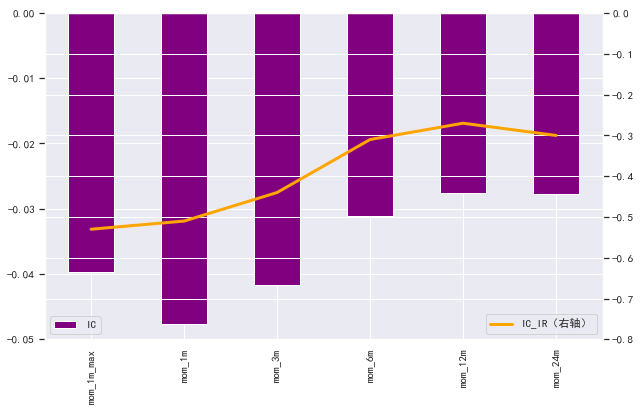

In [6]:
fig,ax = plt.subplots(figsize=(10,6))
ax1 = ax.twinx()
table['IC'].apply(lambda x:float(x.strip('%'))/100).plot(kind='bar',ax=ax,label='IC',color='purple')
table['IC_IR'].plot(ax=ax1,label='IC_IR（右轴）',lw=3,color='orange')
ax1.set_ylim((-0.8,0))
ax.legend(loc='lower left')
ax1.legend(loc='lower right')

##### 这里分析和前面的类似，结论和研报类似，mom_1m有最好的IC表现，另外从IC和ICIR的不同可以发现mom_1m的IC波动率是要更大的，因为它的ic最高但是ICIR却低于mom_1m_max， 也就是mom_1m有着最好的IC均值但是它相对其他因子IC可能波动会更大一点 

####  【4】原始动量因子多空夏普、单调性、换手率情况

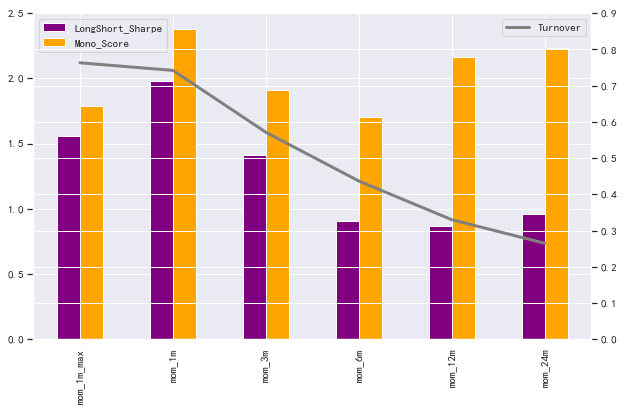

In [7]:
fig,ax = plt.subplots(figsize=(10,6))
ax1 = ax.twinx()
table['Turnover'].apply(lambda x:float(x.strip('%'))/100).plot(ax=ax1,color='gray',lw=3)
table[['LongShort_Sharpe','Mono_Score']].plot(ax=ax,kind='bar',color=['purple','orange'])
ax1.set_ylim((0,0.9))
ax.legend(loc='upper left')
ax1.legend(loc='upper right')

##### 前面分析过了，这边换手率走势和研报是一致的，其他部分略有不同

####  【5】Momentum_1M 测试内容复现

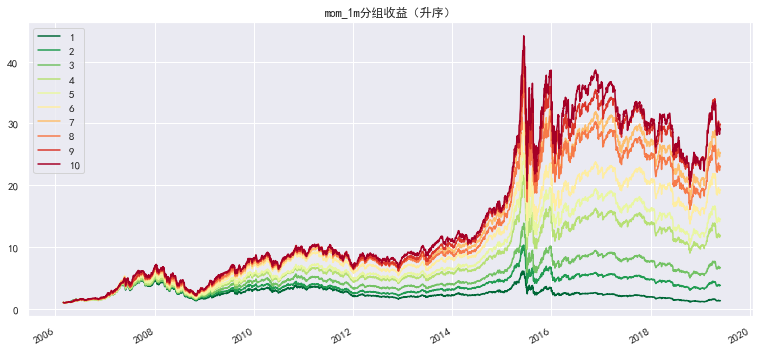

In [8]:
mom_1m_test.create_group_nvplot(10)

##### 这里和研报的回测图对比会发现其实前面几组的走势是非常相近的，研报中最上面几组的曲线基本也长这样，不同点在于顺序和下面几组，研报中首组并不在最上方，而我构造的动量因子回测结果来看首组是表现最好的，也就是它本身就有不错的单调性和多空效果，这也解释了为什么前面的一些结果和研报不同，另外这也会使得后面的一些结论不同

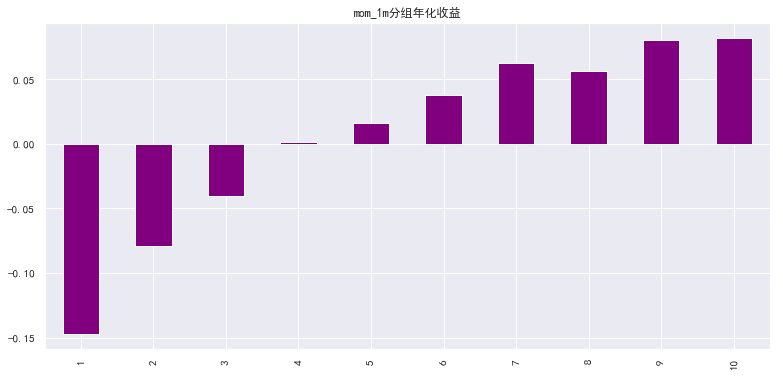

In [9]:
mom_1m_test.create_group_excessmkt_annual_ret(10)

#####  结论是前6组年化超额收益有不错的单调性，但在7组开始单调性就不太明显了，整体上和研报是类似的只是出现分界的组别不同

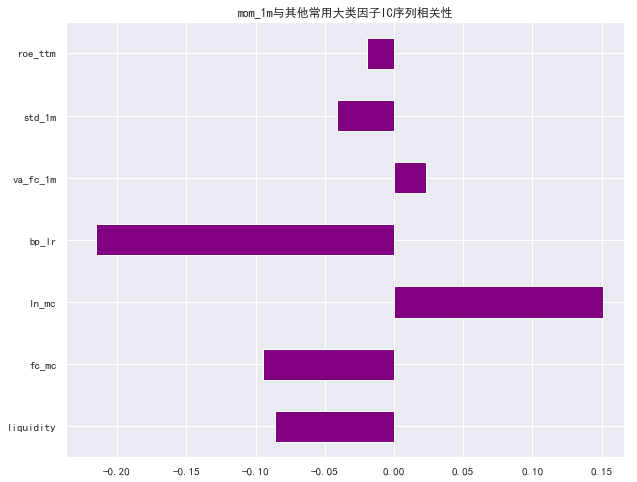

In [10]:
mom_1m_test.create_iccorrwith_factors()

#####  这一部分可以看到mom_1m确实和fc_mc和流动性因子有一定相关性，这里整体上和研报是接近的
##### 另外后面的部分有些不同，还有这里常用大类因子的种类和顺序也不尽相同，以及具体研报是用的怎么获取的大类因子也会有影响，我这里是直接从聚宽读取了，个人觉得这部分就稍微看看就好，后面不过多解释，具体可以查看这部分的代码

###  研报复现第二部分：结合均线的趋势动量因子

####  【1】把因子传入类

In [11]:
ma_20_test = Factor_test(ma_20, 'ma_20', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)
ma_60_test = Factor_test(ma_60, 'ma_60', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)
ma_120_test = Factor_test(ma_120, 'ma_120', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)
ma_240_test = Factor_test(ma_240, 'ma_240', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)

开始传入因子
因子传入完成 耗时21.572 秒
开始传入因子
因子传入完成 耗时12.706 秒
开始传入因子
因子传入完成 耗时11.291 秒
开始传入因子
因子传入完成 耗时21.988 秒


####  【2】趋势动量因子测试结果

In [12]:
table2 = pd.DataFrame()
for t in tqdm((ma_20_test,ma_60_test,ma_120_test,ma_240_test)):
    table2 = table2.append(t.cal_some_para(rev=True))
display(table2)

100%|██████████| 4/4 [00:19<00:00,  5.02s/it]


,IC,IC_IR,LongShort_Sharpe,Mono_Score,Turnover
ma_20,2.40%,0.31,1.44,1.66,65.46%
ma_60,3.50%,0.42,1.86,3.41,75.12%
ma_120,3.31%,0.42,1.74,2.59,75.76%
ma_240,3.20%,0.39,1.68,2.87,76.41%


#####  可以看到ma_60因子各方面表现都比其他因子好，除了换手率较高，不过其他因子的Mono_score并没有研报那么高，但是整体多空夏普都比研报高（实际上这里我比较疑惑，从研报结论来看，研报的ma因子都有着不错的Mono_score，并且年化超额收益单调性也不错，没太明白为什么研报测出来的多空夏普会比较低）

####  【3】MA_60 测试内容复现

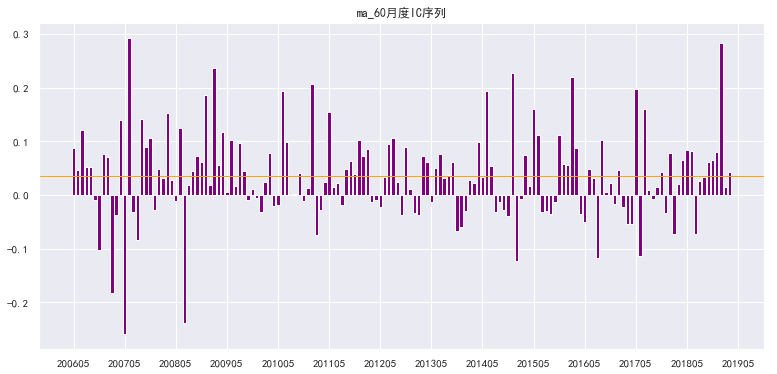

In [13]:
ma_60_test.create_monthic_plot()

#####  月度IC表现，整体上和研报差不多，均值比研报的低一点，不过正向部分似乎更多

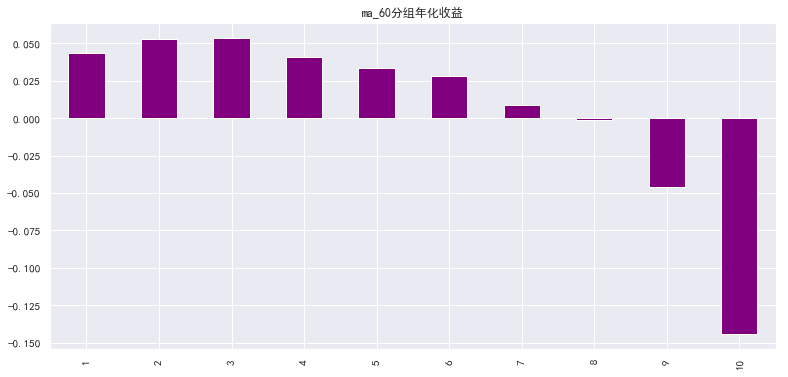

In [14]:
ma_60_test.create_group_excessmkt_annual_ret(10)

#####  这里由于因子IC是正的所以顺序倒过来了，我没去特地调整，和研报相同，最后两组负向收益比较显著，前面几组单调性不太明显

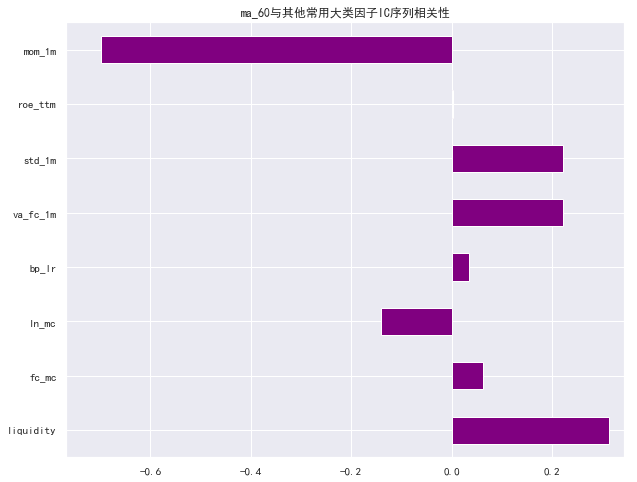

In [15]:
ma_60_test.create_iccorrwith_factors(cal_mom1m=True)

#####  这里不太一样的地方是和一个月动量相关性挺强的，这是我比较疑惑的另一个地方，个人觉得本身这两个因子都是基于动量角度构造的吧应该相关性高挺正常？没太明白，简单看看就好，我也检查过了好多遍代码，应该计算上没出问题吧。。

###  研报复现第三部分：剥离流动性后的提纯因子

####  【1】把因子传入类

In [16]:
mom_1m_neu_test = Factor_test(mom_1m_neu, 'mom_1m_neu', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)

开始传入因子
因子传入完成 耗时12.326 秒


####  【2】提纯动量因子测试结果

In [17]:
table3 = pd.DataFrame()
for t in tqdm((mom_1m_test,mom_1m_neu_test)):
    table3 = table3.append(t.cal_some_para())
display(table3)

100%|██████████| 2/2 [00:14<00:00,  8.24s/it]


,IC,IC_IR,LongShort_Sharpe,Mono_Score,Turnover
mom_1m,-4.77%,-0.51,1.98,2.38,74.20%
mom_1m_neu,-4.22%,-0.46,1.88,2.33,73.99%


#####  可以看到mom_1m整体上都强于提纯动量因子，这里前面有解释过，本身我计算的mom_1m就有不错的单调性和多空夏普，因此这里比提纯动量并不奇怪，研报中主要是首组略差使得多空夏普并不好

####  【3】分组收益表现对比

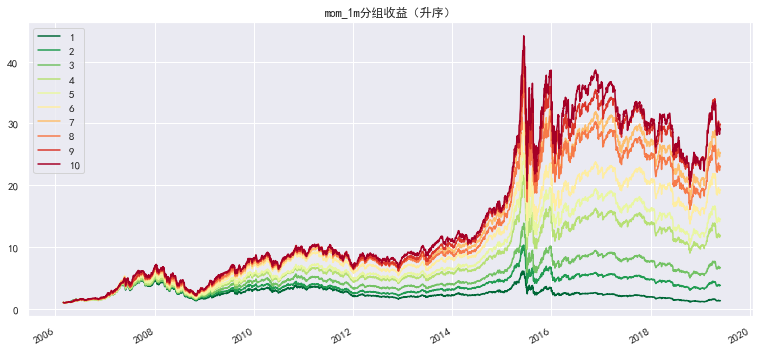

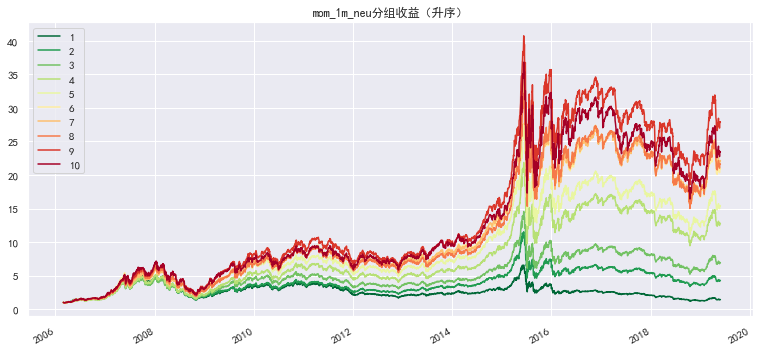

In [18]:
mom_1m_test.create_group_nvplot(10)
mom_1m_neu_test.create_group_nvplot(10)

####  【4】多空收益表现对比

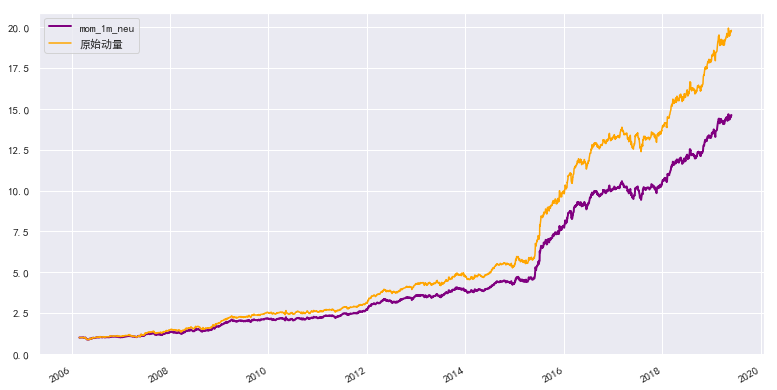

In [19]:
mom_1m_neu_test.create_month_longshort_plot(10,vs_mom1m=True)

#####  这里也看到了原动量的多空是更好的，从前面图中的分组回测对比就可以看到，提纯因子的首组并不是表现最好的一组

####  【5】与大类因子IC序列相关性分析对比

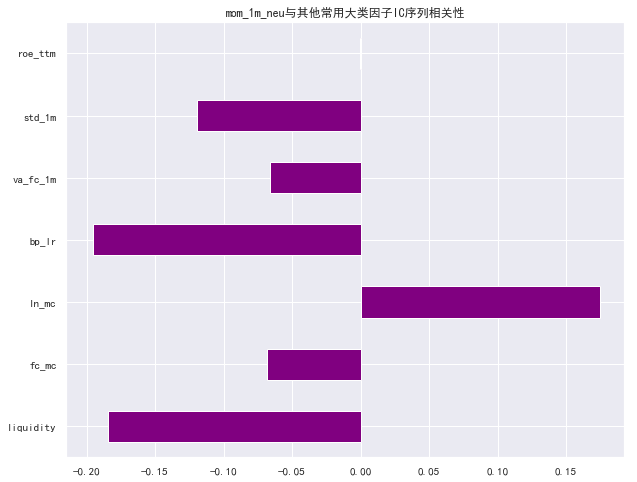

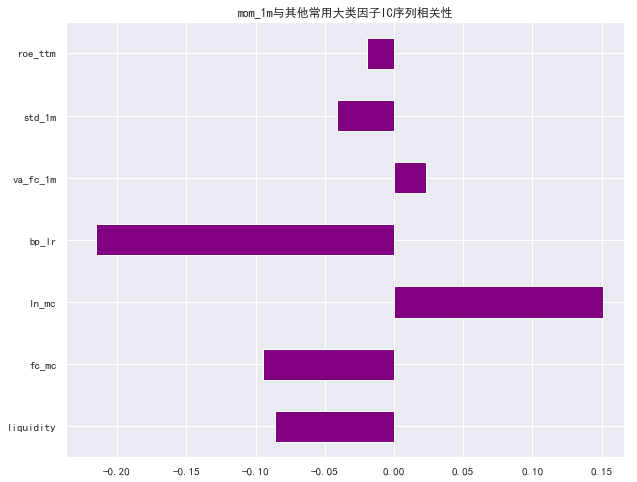

In [20]:
mom_1m_neu_test.create_iccorrwith_factors()
mom_1m_test.create_iccorrwith_factors()

###  研报复现第四部分：风格中性后的残差动量因子

####  【1】把因子传入类

In [21]:
mom_1m_resid_test = Factor_test(mom_1m_resid, 'mom_1m_resid', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=False)

开始传入因子
因子传入完成 耗时11.001 秒


####  【2】残差动量因子测试效果

In [22]:
table4 = pd.DataFrame()
for t in tqdm((mom_1m_test,mom_1m_resid_test)):
    table4 = table4.append(t.cal_some_para())
display(table4)

100%|██████████| 2/2 [00:08<00:00,  4.42s/it]


,IC,IC_IR,LongShort_Sharpe,Mono_Score,Turnover
mom_1m,-4.77%,-0.51,1.98,2.38,74.20%
mom_1m_resid,-5.26%,-0.63,2.33,2.40,73.52%


#####  这里看到残差动量因子表现整体上优于原动量因子（实际上我自己以前测试过特质动量因子，和特质波动率类似它们确实要优于原因子，不过残差的做法也会产生不同结果，计算方法的差异在计算步骤解释了）

####  【3】残差动量因子测试部分

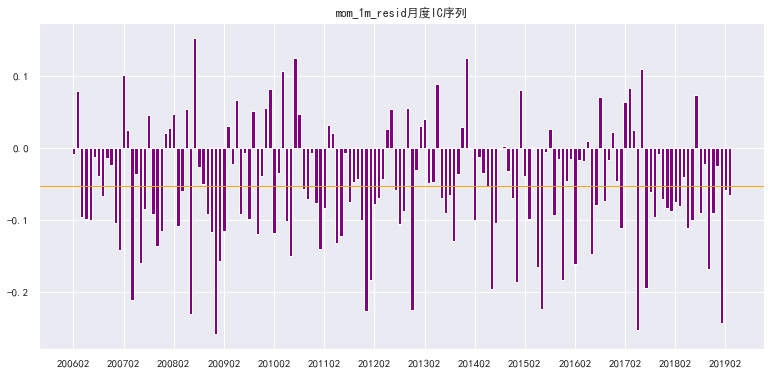

In [23]:
mom_1m_resid_test.create_monthic_plot()

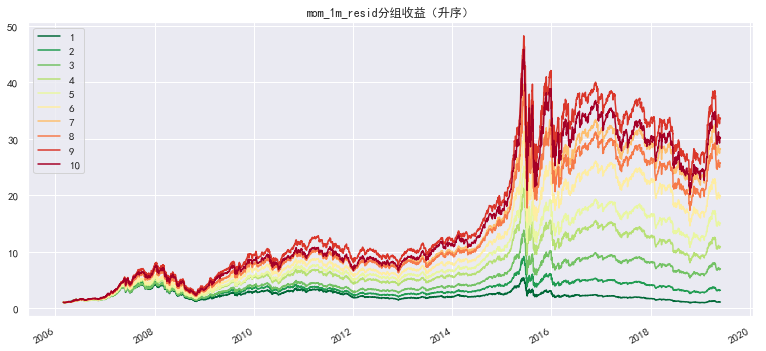

In [24]:
mom_1m_resid_test.create_group_nvplot(10)

#####  这里需要注意纵坐标值和原动量的分组是不同的，虽然首组不再是表现最好的，但可能是由于尾组更差使得多空有了优化（或者首组实际上是略优于原动量首组的，这里的没有详细去对比了，也只是个猜测）

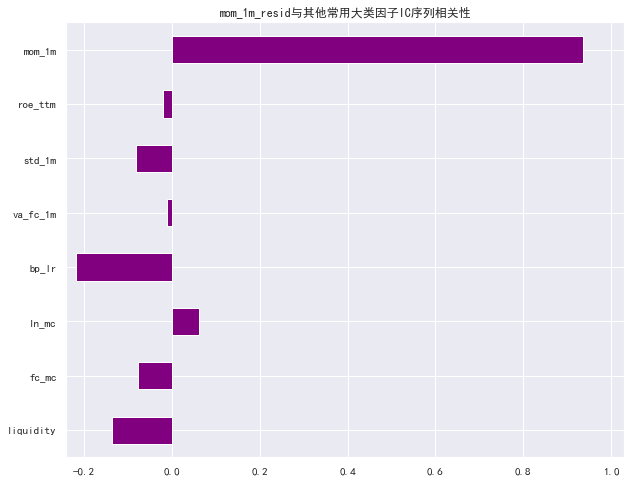

In [25]:
mom_1m_resid_test.create_iccorrwith_factors(cal_mom1m=True)

###  研报复现第五部分：改造k线下的动量因子

####  【1】把因子传入类

In [32]:
value_60_test = Factor_test(value_60, 'value_60', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_120_test = Factor_test(value_120, 'value_120', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
volume_60_test = Factor_test(volume_60, 'volume_60', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
volume_120_test = Factor_test(volume_120, 'volume_120', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)

开始传入因子
因子传入完成 耗时28.018 秒
开始传入因子
因子传入完成 耗时27.62 秒
开始传入因子
因子传入完成 耗时27.005 秒
开始传入因子
因子传入完成 耗时27.578 秒


#####  传入的是月度数据中，把ismonth改成True

####  【2】 改造k线后不同k线动量因子表现

In [33]:
table5 = pd.DataFrame()
for t in tqdm((value_60_test, value_120_test,
               volume_60_test, volume_120_test)):
    table5 = table5.append(t.cal_some_para(to_use_group=1,rev=True,show_group_relative=True))
display(table5)

100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


,IC,IC_IR,Turnover,LongShort_Sharpe,Long_Relative
value_60,5.72%,0.51,60.33%,2.59,19.04%
value_120,4.22%,0.39,51.25%,1.68,15.13%
volume_60,2.91%,0.26,64.48%,1.17,7.10%
volume_120,2.27%,0.20,54.05%,0.71,6.05%


#####  这里的相同点在于value60也是表现最好的，不过它的IC是正的，另外这里时间切分k线因子没有构造了，从研报结论来看时间k线并没有明显优势，而且我做的是中证全指，以上的计算内容已经快整死人了。。再跑tick数据又要很久，8g内存小破电脑顶不太住

####  【3】Value_60 因子测试

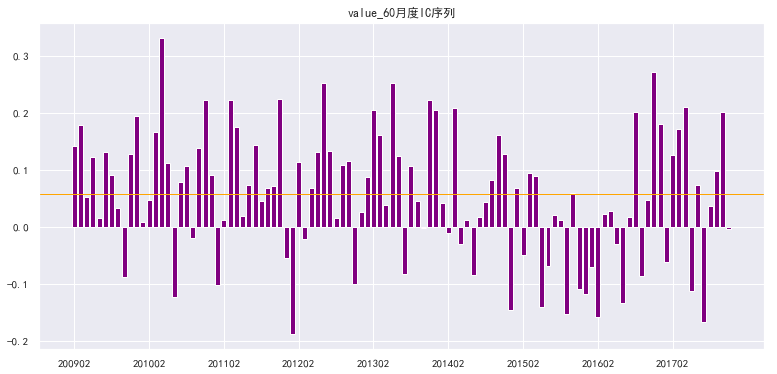

In [34]:
value_60_test.create_monthic_plot()

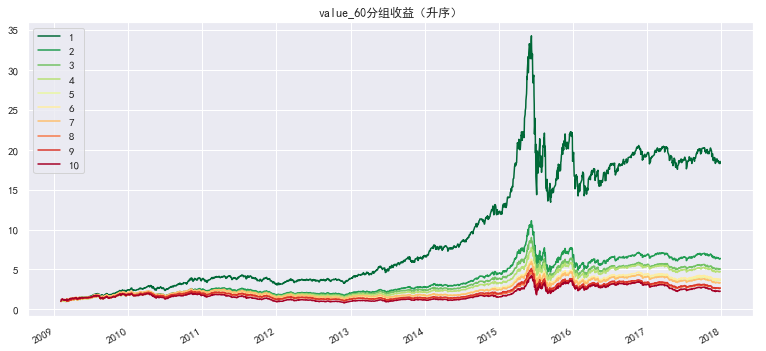

In [35]:
value_60_test.create_group_nvplot(10)

#####  成交额改造k线下多头确实有很不错的表现

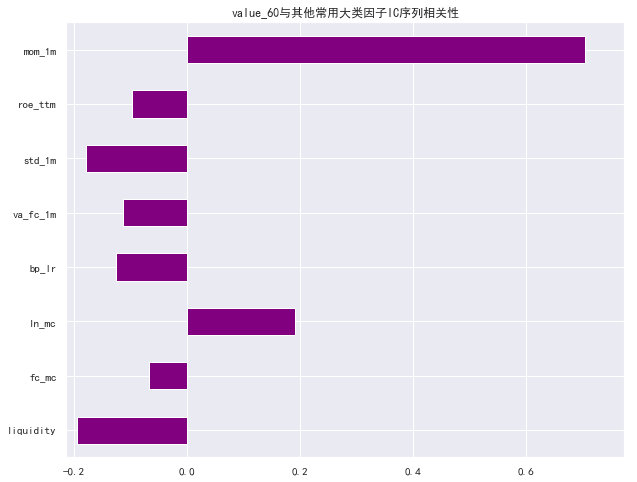

In [36]:
value_60_test.create_iccorrwith_factors(cal_mom1m=True)

##  3）自己的分析部分

###  第一部分：mom_1m 原始动量因子的进一步分析（5，20 period）

####  【1】5 period IC分析

5期,IC均值,IC标准差,ICIR,t值,p值,正IC占比
IC年度表现,,,,,,
2006,-0.04,0.11,-0.39,-5.72,0.0,28.05%
2007,-0.05,0.11,-0.44,-6.87,0.0,34.30%
2008,-0.07,0.12,-0.54,-8.54,0.0,31.30%
2009,-0.06,0.10,-0.60,-9.39,0.0,27.87%
2010,-0.04,0.13,-0.28,-4.39,0.0,40.91%
2011,-0.04,0.11,-0.38,-6.00,0.0,32.79%
2012,-0.05,0.11,-0.47,-7.30,0.0,32.10%
2013,-0.03,0.09,-0.35,-5.41,0.0,38.66%
2014,-0.03,0.09,-0.32,-5.06,0.0,37.55%


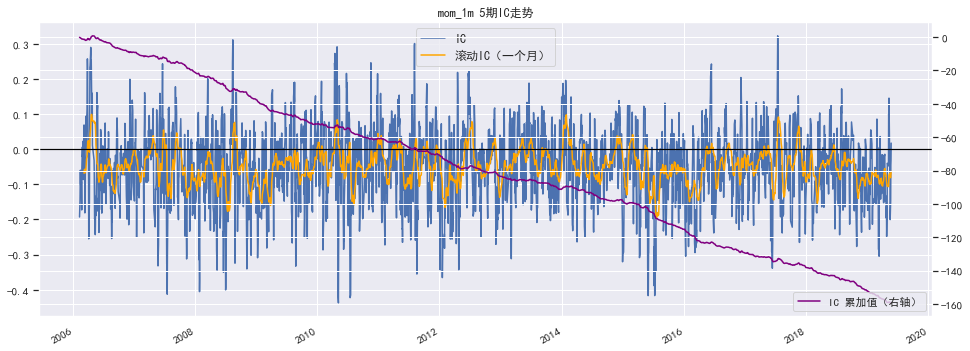

In [37]:
mom_1m_test.create_icreport_byperiod(5)

#####  整体上，滚动IC基本都在负值，ic累加值也基本单调下降，说明IC整体的负向效应是比较明显和稳定的，并不会出现例如突然的IC反转等情况
##### 年度上，IC效果近几年似乎变好了，IC均值提升，负向比例上升
##### 另外这里有个问题。。我应该把IC保留至4位小数的，因为之前复现研报是保留2位成百分数，这里写的时候习惯性保留2位了，后面有些小数差别看不出来，这部分代码中round的部分修改一下就好

####  【2】5 period 分组回测

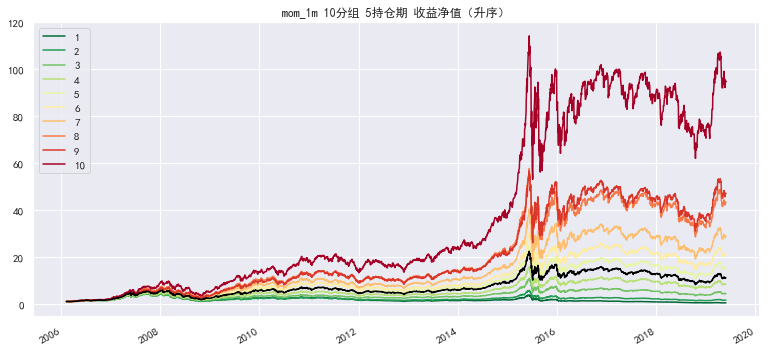

In [38]:
mom_1m_test.create_group_nvplot_by_period(10,5)

####  【3】 5 period 多头分析

,年化收益,年化波动率,最大回撤率,换手率,信息比率
第10组,42.09%,39.90%,65.14%,54.00%,1.05
超额市场,18.62%,7.37%,7.93%,54.00%,2.53
超额中证500,18.01%,8.69%,13.52%,54.00%,2.07


超额市场年度表现,年化收益率,年化波动率,最大回撤率,换手率,信息比率
第10组,,,,,
2006,24.71%,6.95%,5.55%,56.76%,3.55
2007,32.15%,10.98%,7.93%,55.36%,2.93
2008,35.73%,9.88%,6.99%,54.14%,3.62
2009,13.03%,6.53%,4.02%,57.56%,1.99
2010,17.89%,7.06%,4.54%,55.77%,2.53
2011,10.61%,5.86%,4.25%,53.51%,1.81
2012,16.35%,6.36%,4.62%,52.36%,2.57
2013,15.43%,5.53%,3.40%,53.35%,2.79
2014,5.41%,5.55%,3.85%,53.05%,0.97


超额中证500年度表现,年化收益率,年化波动率,最大回撤率,换手率,信息比率
第10组,,,,,
2006,15.48%,8.05%,7.84%,56.76%,1.92
2007,29.03%,11.68%,8.83%,55.36%,2.49
2008,41.93%,10.45%,6.96%,54.14%,4.01
2009,12.16%,7.27%,3.63%,57.56%,1.67
2010,19.22%,7.70%,5.21%,55.77%,2.50
2011,13.07%,6.36%,5.13%,53.51%,2.05
2012,15.14%,7.35%,6.44%,52.36%,2.06
2013,12.87%,6.20%,4.14%,53.35%,2.07
2014,1.16%,7.22%,8.81%,53.05%,0.16


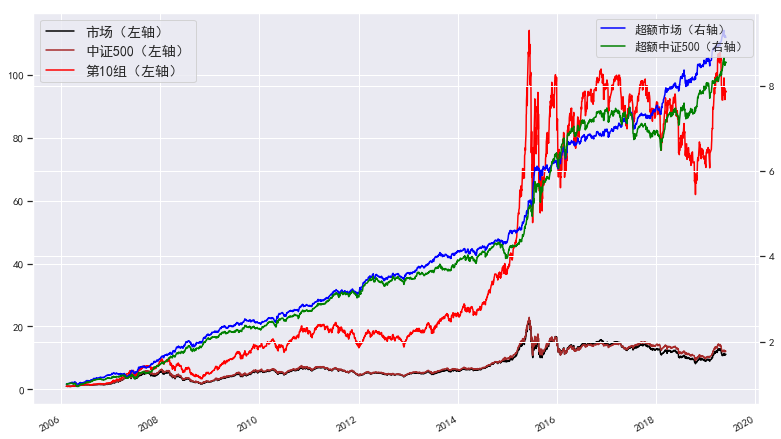

In [39]:
mom_1m_test.create_onegroup_vs_mkt(10,10,5)

#####  可以看到在5日调仓频率下多头表现很不错，但是换手率高是个大问题，而且5天调仓一次也会造成更多成本，整体上这也只是回测的表现，实际策略去实现的话不太现实

####   【4】 5 period 多空分析

多空分年度表现,年化收益率,年化波动率,最大回撤率,换手率,夏普比率
10 组5 持仓期,,,,,
2006,24.04%,15.93%,17.81%,51.79%,1.51
2007,49.80%,20.47%,12.10%,50.42%,2.43
2008,96.39%,20.39%,9.08%,51.30%,4.73
2009,44.01%,14.34%,6.91%,51.28%,3.07
2010,27.24%,17.09%,10.82%,50.76%,1.59
2011,33.10%,12.42%,4.70%,49.18%,2.67
2012,55.07%,12.06%,8.76%,48.19%,4.57
2013,23.98%,14.53%,5.85%,47.56%,1.65
2014,25.77%,10.91%,6.88%,48.31%,2.36


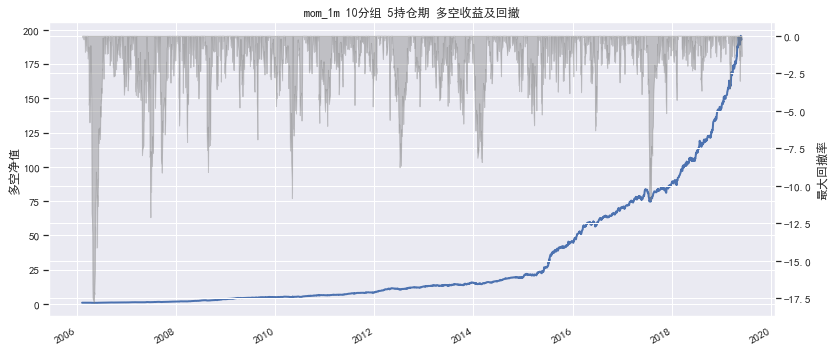

In [40]:
mom_1m_test.create_longshort_report(10,5)

#####  多空也有不错的表现，近几年的回撤，波动率，夏普等都在逐步优化

####  【5】 20 period IC分析

20期,IC均值,IC标准差,ICIR,t值,p值,正IC占比
IC年度表现,,,,,,
2006,-0.03,0.10,-0.35,-5.20,0.0,30.77%
2007,-0.06,0.10,-0.55,-8.48,0.0,29.75%
2008,-0.07,0.11,-0.69,-10.81,0.0,26.83%
2009,-0.06,0.08,-0.77,-12.01,0.0,22.54%
2010,-0.03,0.10,-0.31,-4.85,0.0,38.43%
2011,-0.06,0.11,-0.59,-9.19,0.0,31.15%
2012,-0.06,0.10,-0.57,-8.90,0.0,31.69%
2013,-0.02,0.07,-0.32,-4.87,0.0,37.39%
2014,-0.06,0.08,-0.69,-10.83,0.0,20.00%


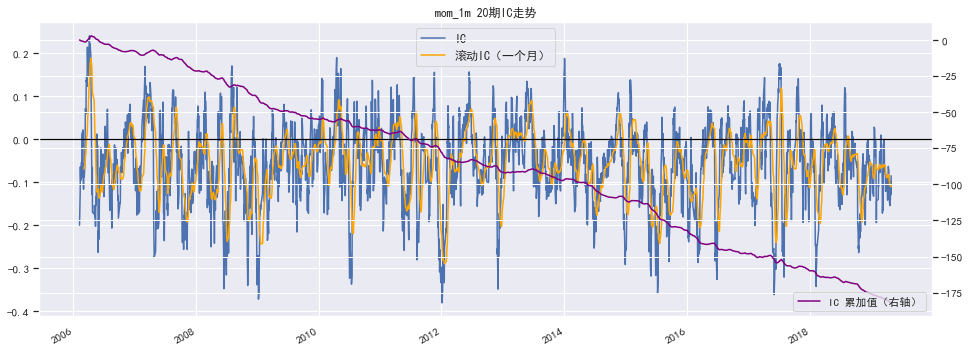

In [41]:
mom_1m_test.create_icreport_byperiod(20, start_date=None, end_date=None)

#####  这里整体效果和之前5日的是比较接近的，重复的分析就不再多说，整体上IC比5期好一点，波动率小一些

####  【6】 20 period 分组回测

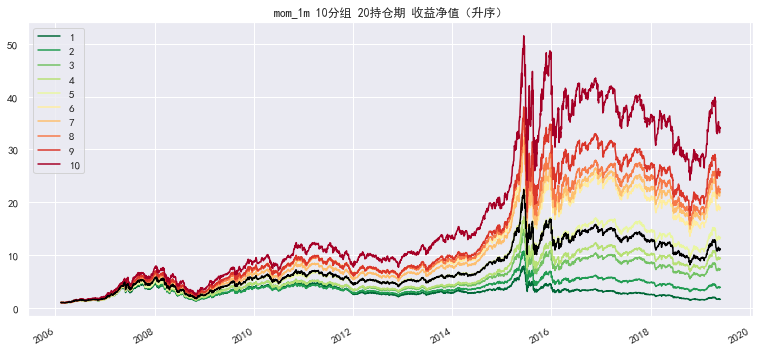

In [42]:
mom_1m_test.create_group_nvplot_by_period(10, 20, start_date=None, end_date=None)

####  【7】 20 period 多头分析

,年化收益,年化波动率,最大回撤率,换手率,信息比率
第10组,31.31%,39.76%,68.85%,91.00%,0.79
超额市场,9.60%,6.73%,10.26%,91.00%,1.43
超额中证500,9.05%,8.00%,19.08%,91.00%,1.13


超额市场年度表现,年化收益率,年化波动率,最大回撤率,换手率,信息比率
第10组,,,,,
2006,24.55%,6.60%,5.87%,92.05%,3.72
2007,10.53%,10.70%,10.26%,89.69%,0.98
2008,11.43%,8.34%,6.91%,90.10%,1.37
2009,4.31%,5.19%,3.80%,91.50%,0.83
2010,12.00%,6.20%,4.08%,91.49%,1.93
2011,4.59%,5.06%,4.67%,91.32%,0.91
2012,14.20%,5.79%,3.55%,92.02%,2.45
2013,13.56%,5.09%,2.46%,92.04%,2.67
2014,-4.16%,5.33%,6.66%,89.90%,-0.78


超额中证500年度表现,年化收益率,年化波动率,最大回撤率,换手率,信息比率
第10组,,,,,
2006,15.30%,8.07%,8.15%,92.05%,1.90
2007,7.99%,10.80%,9.14%,89.69%,0.74
2008,16.54%,8.87%,6.30%,90.10%,1.86
2009,3.50%,6.33%,4.70%,91.50%,0.55
2010,13.28%,6.86%,5.01%,91.49%,1.94
2011,6.92%,5.41%,4.65%,91.32%,1.28
2012,13.01%,6.80%,4.81%,92.02%,1.91
2013,11.04%,5.77%,3.87%,92.04%,1.91
2014,-8.03%,7.14%,12.76%,89.90%,-1.13


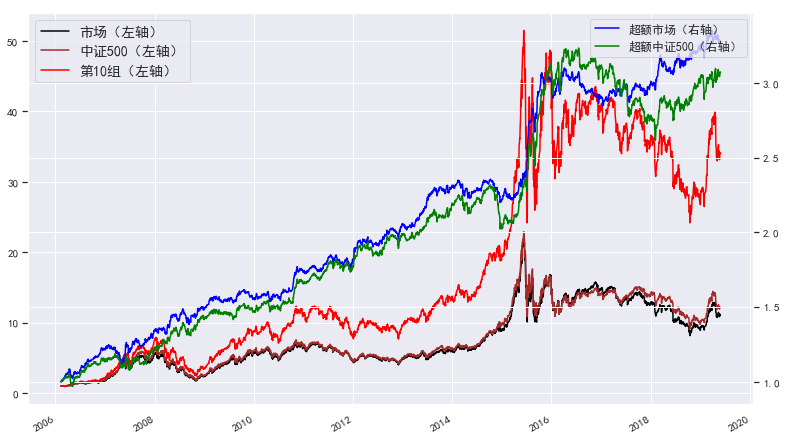

In [43]:
mom_1m_test.create_onegroup_vs_mkt(10, 10, 20)

#####  也是和之前类似，可以看到调仓频率下降后换手率也增长了不少，整体上动量因子还是换手率太高了

####  【8】 20 period 多空分析

多空分年度表现,年化收益率,年化波动率,最大回撤率,换手率,夏普比率
10 组20 持仓期,,,,,
2006,26.99%,14.87%,16.28%,75.42%,1.82
2007,28.82%,18.25%,12.71%,74.47%,1.58
2008,16.64%,16.86%,10.81%,75.74%,0.99
2009,10.49%,11.18%,7.03%,75.72%,0.94
2010,13.15%,13.84%,10.50%,74.89%,0.95
2011,20.23%,10.54%,7.49%,74.01%,1.92
2012,30.72%,10.12%,7.55%,73.11%,3.03
2013,19.20%,11.94%,4.32%,73.85%,1.61
2014,16.77%,9.78%,6.88%,72.31%,1.71


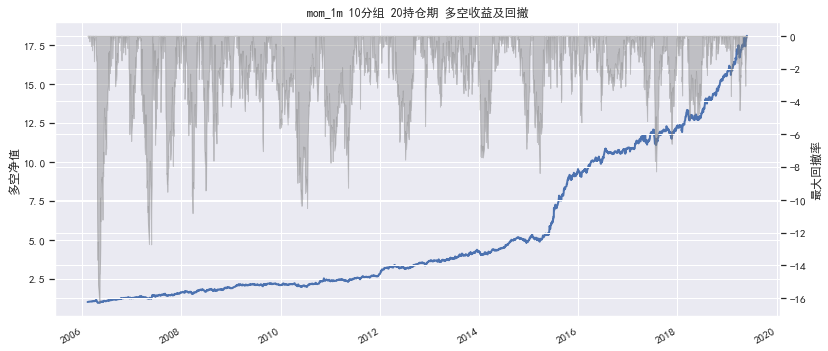

In [44]:
mom_1m_test.create_longshort_report(10,20, start_date=None, end_date=None)

###  第二部分：MA_60 因子的进一步分析（根据前面结论选择表现最好的MA因子）

####  【1】 20 period IC分析

20期,IC均值,IC标准差,ICIR,t值,p值,正IC占比
IC年度表现,,,,,,
2006,0.06,0.06,1.02,13.03,0.0,83.95%
2007,0.03,0.12,0.24,3.80,0.0,55.79%
2008,0.05,0.10,0.47,7.38,0.0,70.73%
2009,0.05,0.07,0.70,10.92,0.0,75.82%
2010,0.04,0.10,0.37,5.76,0.0,61.16%
2011,0.05,0.09,0.57,8.86,0.0,66.80%
2012,0.02,0.07,0.35,5.39,0.0,58.44%
2013,0.02,0.06,0.42,6.52,0.0,65.97%
2014,0.04,0.07,0.49,7.63,0.0,64.49%


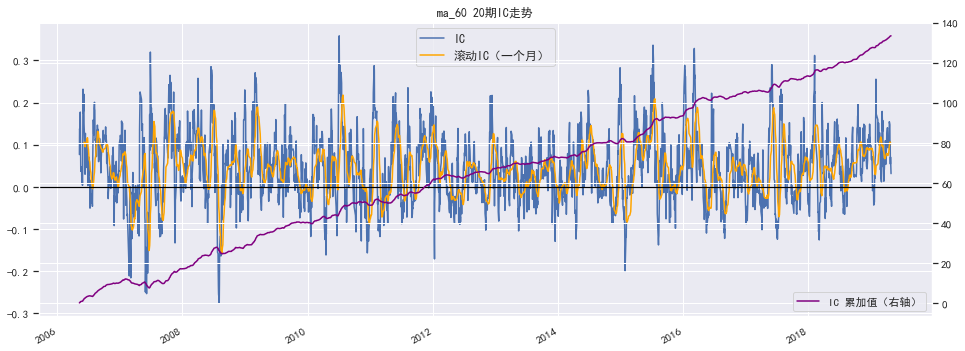

In [45]:
ma_60_test.create_icreport_byperiod(20, start_date=None, end_date=None)

#####  输出的指标都是相同的，分析思路也类似的，从年度的各指标也可以看到ma_60的ic表现在增强

####  【2】 20 period 分组回测

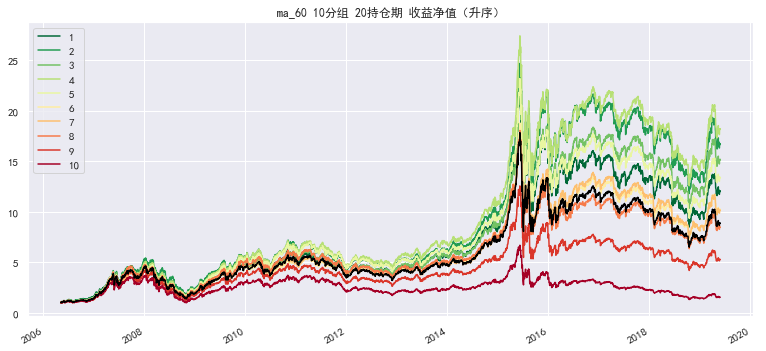

In [46]:
ma_60_test.create_group_nvplot_by_period(10, 20, start_date=None, end_date=None)

#####  这里看到其实ma_60的20期分组效果并不理想，前面几组区分度比较差，IC可能更多来源于尾组显著比其他组差，实际上因子的高IC也并不意味着它能给出不错的分组效果，也有很多因子IC并不高但分组效果还不错

####   【3】 20 period 多空分析

多空分年度表现,年化收益率,年化波动率,最大回撤率,换手率,夏普比率
10 组20 持仓期,,,,,
2006,27.61%,11.89%,5.15%,75.86%,2.32
2007,7.92%,20.77%,16.07%,76.48%,0.38
2008,15.96%,15.31%,8.06%,77.07%,1.04
2009,0.78%,10.04%,4.85%,76.05%,0.08
2010,6.86%,11.06%,7.25%,75.85%,0.62
2011,8.30%,9.09%,7.55%,75.46%,0.91
2012,22.55%,6.73%,7.00%,73.50%,3.35
2013,11.93%,10.29%,5.18%,75.42%,1.16
2014,10.75%,9.33%,7.85%,74.79%,1.15


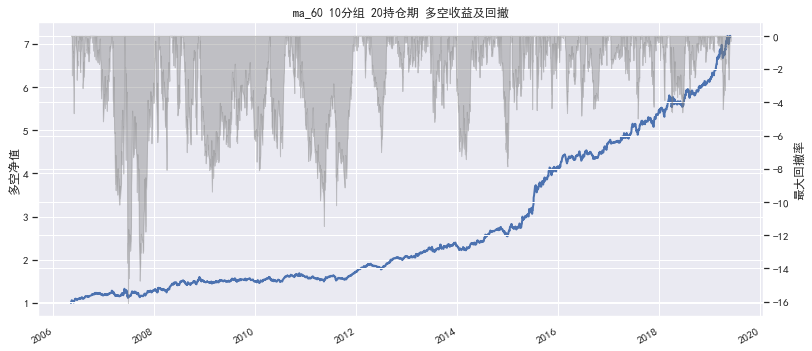

In [47]:
ma_60_test.create_longshort_report(10,20,rev=True, start_date=None, end_date=None)

#####  可以看到，尽管分组不太理想，多空还是不错的，多空只涉及到多头和空头两组，只要因子能够比较好的区分开多头空头，它们的差距持续在拉大，就能有不错的多空走势

###  第三部分：风格中性化后的残差动量因子分析

####  【1】 20 period IC分析

20期,IC均值,IC标准差,ICIR,t值,p值,正IC占比
IC年度表现,,,,,,
2006,-0.05,0.08,-0.61,-9.13,0.0,19.00%
2007,-0.08,0.10,-0.83,-12.85,0.0,23.55%
2008,-0.07,0.11,-0.67,-10.46,0.0,27.64%
2009,-0.06,0.08,-0.77,-11.99,0.0,22.95%
2010,-0.03,0.10,-0.35,-5.37,0.0,38.02%
2011,-0.07,0.11,-0.60,-9.39,0.0,30.33%
2012,-0.06,0.09,-0.63,-9.82,0.0,26.75%
2013,-0.02,0.07,-0.32,-4.98,0.0,39.08%
2014,-0.06,0.07,-0.89,-13.90,0.0,16.73%


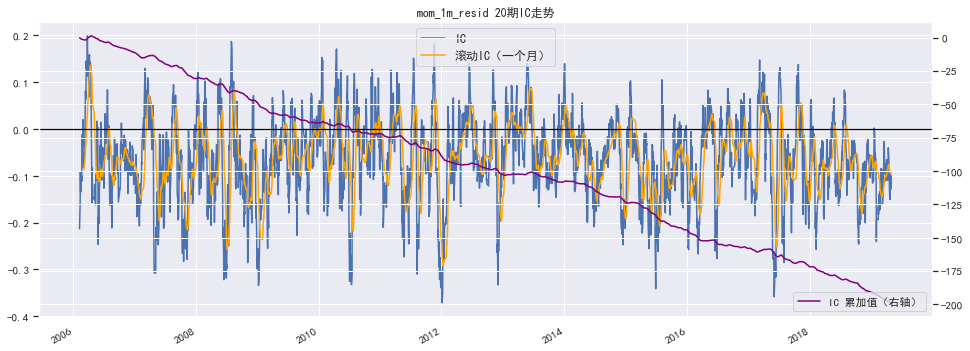

In [48]:
mom_1m_resid_test.create_icreport_byperiod(20, start_date=None, end_date=None)

#####  这里重复的分析不再多说，主要是对比于mom_1m可以看到，残差动量因子IC方面是要优于原动量因子的

####  【2】 20 period 分组回测

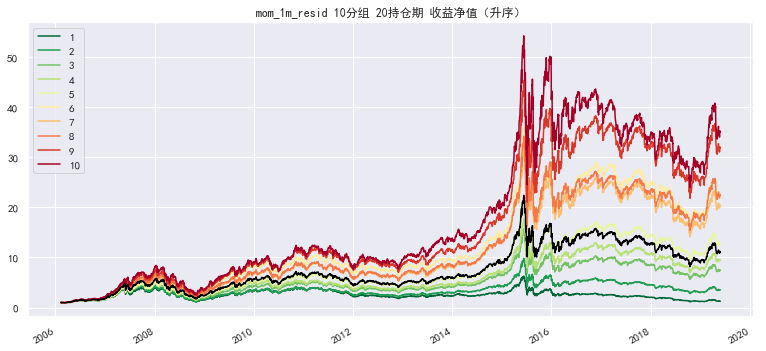

In [49]:
mom_1m_resid_test.create_group_nvplot_by_period(10, 20, start_date=None, end_date=None)

####  【3】 20 period 多头分析

,年化收益,年化波动率,最大回撤率,换手率,信息比率
第10组,31.63%,39.75%,69.28%,90.00%,0.80
超额市场,9.88%,6.48%,12.43%,90.00%,1.53
超额中证500,9.33%,7.78%,23.98%,90.00%,1.20


超额市场年度表现,年化收益率,年化波动率,最大回撤率,换手率,信息比率
第10组,,,,,
2006,22.89%,6.22%,4.81%,91.47%,3.68
2007,18.29%,9.83%,6.92%,90.86%,1.86
2008,8.10%,7.92%,6.34%,90.25%,1.02
2009,5.52%,5.19%,4.44%,89.17%,1.06
2010,8.31%,5.78%,4.66%,89.98%,1.44
2011,4.08%,5.03%,5.08%,90.38%,0.81
2012,13.67%,5.36%,2.84%,91.22%,2.55
2013,15.57%,4.54%,1.89%,91.06%,3.43
2014,1.28%,5.28%,6.02%,88.25%,0.24


超额中证500年度表现,年化收益率,年化波动率,最大回撤率,换手率,信息比率
第10组,,,,,
2006,13.80%,7.43%,7.12%,91.47%,1.86
2007,15.61%,9.69%,5.65%,90.86%,1.61
2008,13.05%,8.54%,6.03%,90.25%,1.53
2009,4.70%,6.27%,4.05%,89.17%,0.75
2010,9.53%,6.64%,5.52%,89.98%,1.44
2011,6.39%,5.55%,4.86%,90.38%,1.15
2012,12.49%,6.50%,4.16%,91.22%,1.92
2013,13.01%,5.32%,3.26%,91.06%,2.45
2014,-2.78%,6.75%,9.86%,88.25%,-0.41


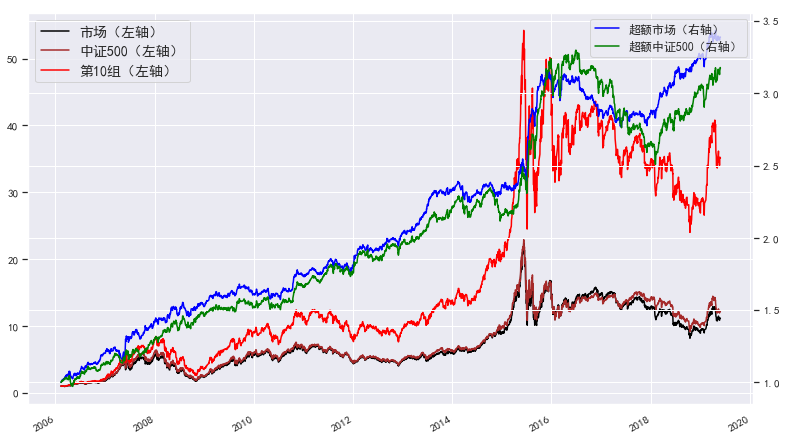

In [50]:
mom_1m_resid_test.create_onegroup_vs_mkt(10, 10, 20)

#####   这里对比原动量因子可以看到残差动量的多头表现是更好的

####  【4】 20 period 多空分析

多空分年度表现,年化收益率,年化波动率,最大回撤率,换手率,夏普比率
10 组20 持仓期,,,,,
2006,29.39%,14.11%,15.31%,75.32%,2.08
2007,52.94%,17.68%,9.22%,75.31%,2.99
2008,15.68%,16.04%,9.50%,75.72%,0.98
2009,12.46%,11.31%,6.49%,74.94%,1.10
2010,9.90%,13.64%,10.99%,74.46%,0.73
2011,20.39%,10.34%,7.43%,73.27%,1.97
2012,29.74%,9.59%,6.11%,72.21%,3.10
2013,25.33%,11.68%,4.36%,73.26%,2.17
2014,26.69%,9.39%,4.65%,71.36%,2.84


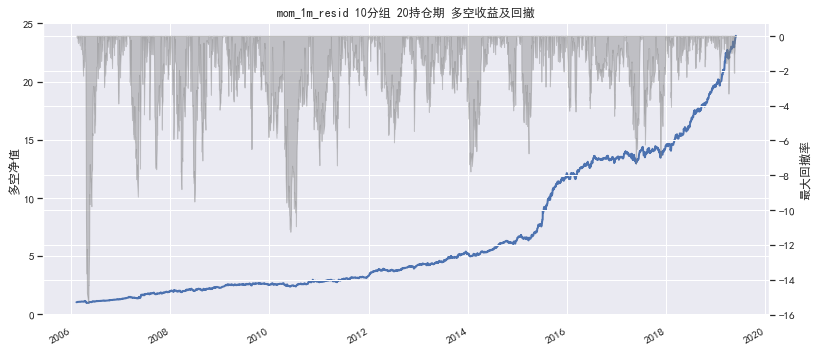

In [51]:
mom_1m_resid_test.create_longshort_report(10,20, start_date=None, end_date=None)

#####  多空也是残差动量因子表现更好，应该也有部分得益于更好的IC表现

###  第四部分：改造k线因子参数敏感性分析（以成交额k线为例）

#####  下面的几个改造k线因子计算我没有在上面写了，计算方式和上面是一模一样的，这里就直接算好读取了
##### 参数的一点解释：
##### 60 90 120是计算动量使用的改造k线根数，即用60根k线的close pctchange计算动量等
##### 5 10 15 是改造k线时设定的改造k线总根数相对于日k线，5表示下取整后比日k多500根，例如有1630根日k线那么在5参数下的含义是构造的改造k线为1600+500=2100根，10就是2600根，15就是3100根，具体可以参考之前的计算代码
##### 敏感性分析即在不同的参数组合下，取出因子的多头年化超额收益进行对比分析（当然只看多头整体的超额收益也略片面，这里只是简单分析一下就暂时不进行更加深入的研究）

In [52]:
value_60 = pd.read_csv('money60_neutralized.csv',index_col=0,parse_dates=True)
value_60_5 = pd.read_csv('money60_5_neutralized.csv',index_col=0,parse_dates=True)
value_60_15 = pd.read_csv('money60_15_neutralized.csv',index_col=0,parse_dates=True)
value_90 = pd.read_csv('money90_neutralized.csv',index_col=0,parse_dates=True)
value_90_5 = pd.read_csv('money90_5_neutralized.csv',index_col=0,parse_dates=True)
value_90_15 = pd.read_csv('money90_15_neutralized.csv',index_col=0,parse_dates=True)
value_120 = pd.read_csv('money120_neutralized.csv',index_col=0,parse_dates=True)
value_120_5 = pd.read_csv('money120_5_neutralized.csv',index_col=0,parse_dates=True)
value_120_15 = pd.read_csv('money120_15_neutralized.csv',index_col=0,parse_dates=True)

value_60_test = Factor_test(value_60, 'value_60', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_60_5_test = Factor_test(value_60_5, 'value_60_5', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_60_15_test = Factor_test(value_60_15, 'value_60_15', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_90_test = Factor_test(value_90, 'value_90', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_90_5_test = Factor_test(value_90_5, 'value_90_5', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_90_15_test = Factor_test(value_90_15, 'value_90_15', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_120_test = Factor_test(value_120, 'value_120', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_120_5_test = Factor_test(value_120_5, 'value_120_5', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)
value_120_15_test = Factor_test(value_120_15, 'value_120_15', open_, close, paused, st,
                mom_1m, roe_ttm, va_fc_1m, bp_lr, ln_mc, liquidity, fc_mc,
                ismonth=True)

开始传入因子
因子传入完成 耗时29.114 秒
开始传入因子
因子传入完成 耗时27.97 秒
开始传入因子
因子传入完成 耗时29.175 秒
开始传入因子
因子传入完成 耗时29.506 秒
开始传入因子
因子传入完成 耗时27.875 秒
开始传入因子
因子传入完成 耗时29.198 秒
开始传入因子
因子传入完成 耗时31.973 秒
开始传入因子
因子传入完成 耗时26.299 秒
开始传入因子
因子传入完成 耗时30.366 秒


,5,10,15
60,0.2109,0.1904,0.1694
90,0.1637,0.1307,0.139
120,0.1265,0.1513,0.1122


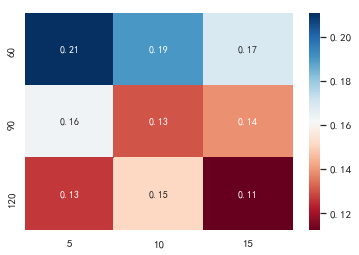

In [53]:
table7 = pd.DataFrame(index=[60,90,120],columns=[5,10,15])
table7.loc[60,5] = float(value_60_5_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
table7.loc[60,10] = float(value_60_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
table7.loc[60,15] = float(value_60_15_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
table7.loc[90,5] = float(value_90_5_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
table7.loc[90,10] = float(value_90_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
table7.loc[90,15] = float(value_90_15_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
table7.loc[120,5] = float(value_120_5_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
table7.loc[120,10] = float(value_120_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
table7.loc[120,15] = float(value_120_15_test.cal_some_para(to_use_group=1,rev=True,show_group_relative=True).iloc[0,-1].split('%')[0])/100
display(table7)
table7[list(table7.columns)]=table7[list(table7.columns)].astype(float)
sns.heatmap(table7,annot=True, cmap='RdBu')

#####  从得到的heatmap图可以看到，参数的变动使得多头的超额收益有比较明显的单调性（尽管在10，120这里不同），从图上可以简单认为，改造k线总根数越少，多头超额收益越高，计算动量使用的k线根数越少，多头超额收益越高（当然不能太少了，理想情况下应该测试更多的参数组合，这里就简单以3*3展示了）
####  关于参数组合的个人理解：
#### 我觉得不管是总k线根数还是计算动量的根数，实际上都是在控制计算动量时间隔的成交额应该为多少，总k线根数算是先给间隔限定一个大的范围，不同的总根数对应不同的范围，越多表现切分后每只股票中每根k线对应的成交额越少，而计算使用的根数则是在确定了这些间隔成交额后进一步计算采用的成交额
#### emm举个栗子，总k线首先限定了一个大范围，使用的k线再在这个大范围下确定小范围
#### 例如对某只股票，在5这个参数下，它对应着每根k线代表10000的成交额（随便举的，数值太大也不方便理解吧），那么这时候60 90 120对应间隔600000 900000 1200000 成交额的动量
#### 而在10这个参数下，它对应每根k线代表6000成交额，那么60 90 120对应间隔 360000 540000 720000成交额的动量，以此类推
#### 大概就是实际上这两个参数可以互相转换，比如我在10这个参数下让计算用的k线更多，应该可以去接近5参数下计算用的k线较少的效果，都是在控制间隔的成交额

####   最后是策略，因为多空不太现实，这里就简单测试了一下结合几个因子的纯多头，选择多头表现最好的value60_5因子的多头前50只，并结合mom_1m10分组, ma_60 15分组的空头组剔除，在13年到16年底回测，确实有不错的收益，超额也在持续增长
#### 另外用同样的方法计算了改造成交额k线在19年的因子值，具体计算方法相同，每个月月初，用上个月末回溯到12年的数据计算，并得到最后一次收盘价的改造K线动量作为当月因子值，同样选择多头前50只，结合mom_1m10分组, ma_60 15分组的空头组剔除，在19年1.1回测至7.22，还是有一定超额收益的，不过效果比之前的要差了
#### 回测基准都是中证500，手续费设置都是买入时佣金万分之三，卖出时佣金万分之三加千分之一印花税, 每笔交易佣金最低扣5块钱，都是月初调仓，另外回测由于直接计算改造k线比较耗时，我先在研究环境算好了每月的因子值直接读入的，计算方式前面提到了，用前一天开始回溯计算
#### 缺点是计算比较耗时，因为回溯的时长太久了，我还没找到参数让短期回溯下效果和长期类似，就暂时先用长期回溯计算，寻找参数还有点麻烦，不过应该是可以找到短期回溯的参数如短期回溯设定多少根改造k线，用多少根计算这样，这样计算就方便很多不用每次都回溯到12年，可能一两个月两三个月就行

###  历史回测如下

![历史回测](D:/yanbaofux/历史回测.png)

### 19年回测如下

![19年回测](D:/yanbaofux/19年回测.png)